# Objective

- Daily records of air pollutant concentrations collected over time, including PM2.5, PM10, NO₂, SO₂, CO, and Ozone. It also logs the Air Quality Index (AQI), along with date (day, month, year) also includes number of holidays and weekday representation.
- It is ideal for developing models to predict AQI, study pollution patterns, and analyze the effects of temporal or holiday factors on air quality.

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

### File Reading

In [2]:
df = pd.read_csv("final_dataset.csv")

df["Date"] = pd.to_datetime(
    df[["Year", "Month", "Date"]].rename(columns={"Date": "Day"})
)
df = df.sort_values("Date").set_index("Date")
print(df.head(5))
print(df.columns)

            Month  Year  Holidays_Count  Days   PM2.5    PM10     NO2    SO2  \
Date                                                                           
2021-01-01      1  2021               0     5  408.80  442.42  160.61  12.95   
2021-01-02      1  2021               0     6  404.04  561.95   52.85   5.18   
2021-01-03      1  2021               1     7  225.07  239.04  170.95  10.93   
2021-01-04      1  2021               0     1   89.55  132.08  153.98  10.42   
2021-01-05      1  2021               0     2   54.06   55.54  122.66   9.70   

              CO  Ozone  AQI  
Date                          
2021-01-01  2.77  43.19  462  
2021-01-02  2.60  16.43  482  
2021-01-03  1.40  44.29  263  
2021-01-04  1.01  49.19  207  
2021-01-05  0.64  48.88  149  
Index(['Month', 'Year', 'Holidays_Count', 'Days', 'PM2.5', 'PM10', 'NO2',
       'SO2', 'CO', 'Ozone', 'AQI'],
      dtype='object')


### Exploratory Data Analysis

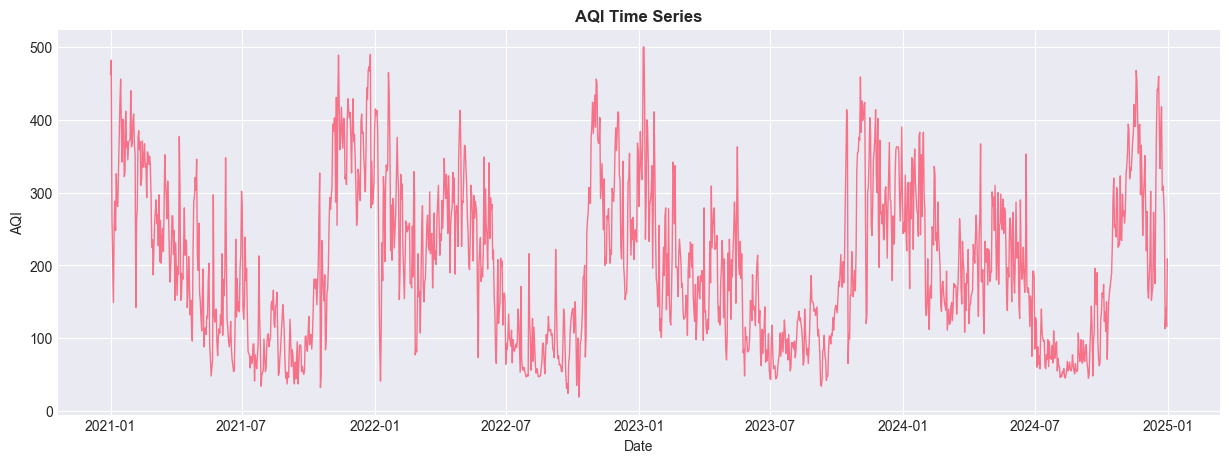

In [3]:
plt.figure(figsize=(15,5))
plt.plot(df.index, df["AQI"], linewidth=1)
plt.title("AQI Time Series", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.savefig('aqi-time-series.png')
plt.show()

Outliers detected: 0 (0.00%)


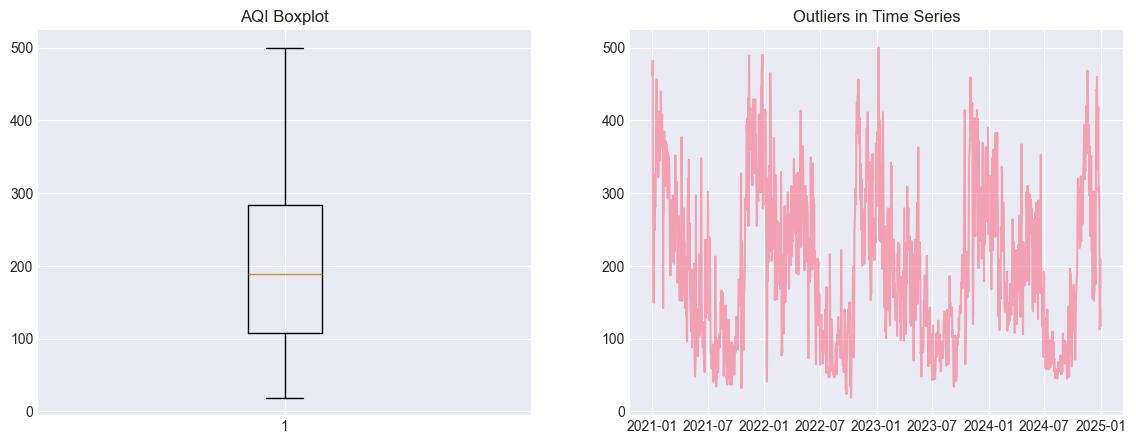

In [4]:
# outlier detection

Q1, Q3 = df["AQI"].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR

z_scores = np.abs(stats.zscore(df["AQI"]))
outliers = (df["AQI"] < lower) | (df["AQI"] > upper) | (z_scores > 3)

print(f"Outliers detected: {outliers.sum()} ({outliers.mean()*100:.2f}%)")

fig, axes = plt.subplots(1, 2, figsize=(14,5))

axes[0].boxplot(df["AQI"])
axes[0].set_title("AQI Boxplot")

axes[1].plot(df.index, df["AQI"], alpha=0.6)
axes[1].scatter(df.index[outliers], df["AQI"][outliers], color="red", s=15)
axes[1].set_title("Outliers in Time Series")

plt.savefig('outlier-detect.png')
plt.show()

In [5]:
df["AQI"] = np.clip(df["AQI"], lower, upper)

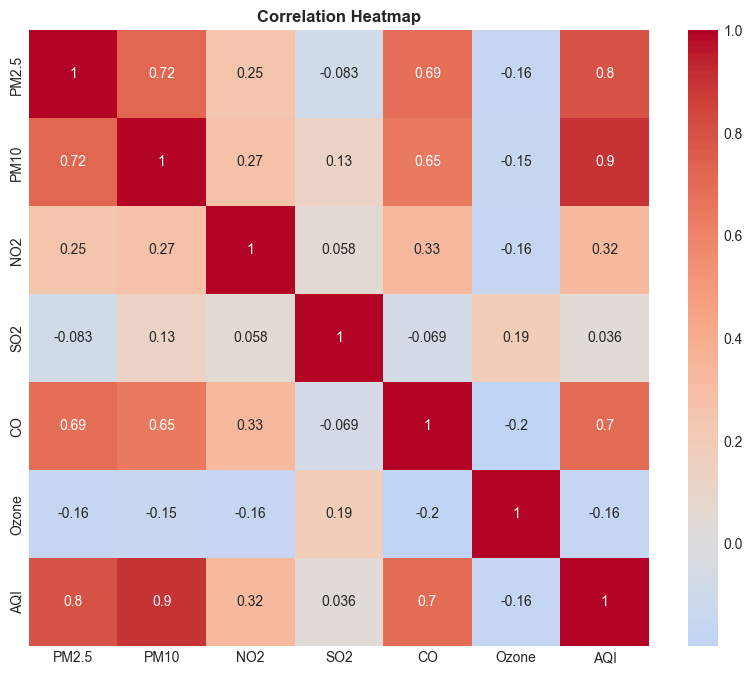

In [6]:
pollutants = ["PM2.5", "PM10", "NO2", "SO2", "CO", "Ozone", "AQI"]
corr = df[pollutants].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap", fontweight="bold")
plt.savefig('heatmap.png')
plt.show()

### Feature Engineering

In [7]:
# ============================================
# FEATURE ENGINEERING
# ============================================

print(f"Original features: {df.shape[1]}")
print(f"Original samples: {df.shape[0]}")

# Cyclical encoding for Month (important for seasonality)
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# Day of week encoding (if you have day info)
if 'Days' in df.columns:
    df['Day_sin'] = np.sin(2 * np.pi * df['Days'] / 7)
    df['Day_cos'] = np.cos(2 * np.pi * df['Days'] / 7)

# Quarter of the year
df['Quarter'] = (df['Month'] - 1) // 3 + 1

# Season (meteorological seasons)
def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Autumn

df['Season'] = df['Month'].apply(get_season)

# Is weekend (if Days represents day of week, 1=Monday, 7=Sunday)
if 'Days' in df.columns:
    df['Is_Weekend'] = (df['Days'] >= 6).astype(int)


pollutant_cols = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Ozone', 'AQI']
lag_features_created = 0

for col in pollutant_cols:
    # 1-day, 2-day, 3-day lags
    for lag in [1, 2, 3, 7]:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)
        lag_features_created += 1

print(f"   ✓ Created {lag_features_created} lag features")

rolling_features_created = 0

for col in pollutant_cols:
    # 3-day rolling mean
    df[f'{col}_roll3_mean'] = df[col].rolling(window=3, min_periods=1).mean()
    
    # 7-day rolling mean
    df[f'{col}_roll7_mean'] = df[col].rolling(window=7, min_periods=1).mean()
    
    # 3-day rolling std (volatility)
    df[f'{col}_roll3_std'] = df[col].rolling(window=3, min_periods=1).std()
    
    # 7-day rolling min/max
    df[f'{col}_roll7_min'] = df[col].rolling(window=7, min_periods=1).min()
    df[f'{col}_roll7_max'] = df[col].rolling(window=7, min_periods=1).max()
    
    rolling_features_created += 5

print(f"   ✓ Created {rolling_features_created} rolling statistics")

diff_features_created = 0

for col in pollutant_cols:
    # First difference (day-to-day change)
    df[f'{col}_diff1'] = df[col].diff(1)
    
    # Percentage change
    df[f'{col}_pct_change'] = df[col].pct_change(1)
    
    diff_features_created += 2

print(f"   ✓ Created {diff_features_created} rate of change features")

# PM2.5 to PM10 ratio (fine to coarse particle ratio)
df['PM2.5_to_PM10_ratio'] = df['PM2.5'] / (df['PM10'] + 1e-6)

# Pollutant index combinations
df['PM_total'] = df['PM2.5'] + df['PM10']
df['Gas_total'] = df['NO2'] + df['SO2'] + df['CO']

# PM2.5 * NO2 interaction (common in urban pollution)
df['PM2.5_NO2_interaction'] = df['PM2.5'] * df['NO2']

# Holiday impact on pollutants
df['Holiday_PM2.5'] = df['Holidays_Count'] * df['PM2.5']

# Mean of all pollutants
df['Pollutants_Mean'] = df[['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Ozone']].mean(axis=1)

# Std of all pollutants (measure of variation)
df['Pollutants_Std'] = df[['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Ozone']].std(axis=1)

# Max pollutant value
df['Pollutants_Max'] = df[['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Ozone']].max(axis=1)

# Min pollutant value
df['Pollutants_Min'] = df[['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Ozone']].min(axis=1)

ema_features_created = 0

for col in ['PM2.5', 'PM10', 'NO2', 'AQI']:
    # EMA with different spans
    df[f'{col}_ema3'] = df[col].ewm(span=3, adjust=False).mean()
    df[f'{col}_ema7'] = df[col].ewm(span=7, adjust=False).mean()
    ema_features_created += 2

# Air Quality Category (based on AQI ranges)
def aqi_category(aqi):
    if aqi <= 50:
        return 0  # Good
    elif aqi <= 100:
        return 1  # Moderate
    elif aqi <= 150:
        return 2  # Unhealthy for Sensitive
    elif aqi <= 200:
        return 3  # Unhealthy
    elif aqi <= 300:
        return 4  # Very Unhealthy
    else:
        return 5  # Hazardous

df['AQI_Category'] = df['AQI'].apply(aqi_category)

# PM2.5 dominance (when PM2.5 is the major pollutant)
df['PM2.5_Dominant'] = (df['PM2.5'] > df['PM10'] * 0.6).astype(int)

# High pollution day indicator
df['High_Pollution_Day'] = (df['AQI'] > 100).astype(int)

rows_before = len(df)
df = df.dropna().reset_index(drop=True)
rows_after = len(df)

print(f"   Removed {rows_before - rows_after} rows with NaN values")

print(f"Original features: 11")
print(f"New features created: {df.shape[1] - 11}")
print(f"Total features: {df.shape[1]}")
print(f"Samples after cleaning: {df.shape[0]}")

# Save engineered dataset
df.to_csv('air_quality_engineered.csv', index=False)
print(f"\n✅ Engineered dataset saved as 'air_quality_engineered.csv'")

Original features: 11
Original samples: 1461
   ✓ Created 28 lag features
   ✓ Created 35 rolling statistics
   ✓ Created 14 rate of change features
   Removed 7 rows with NaN values
Original features: 11
New features created: 104
Total features: 115
Samples after cleaning: 1454

✅ Engineered dataset saved as 'air_quality_engineered.csv'


### Ensemble Machine Learning Models

In [8]:
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
# Define features and target
target_variable = 'AQI'  # Change this to predict other pollutants
feature_columns = [
    # Original pollutants
    'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Ozone',
    
    # Temporal features
    'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 
    'Quarter', 'Season', 'Is_Weekend', 'Holidays_Count',
    
    # Lag features (1, 2, 3, 7 days)
    'PM2.5_lag1', 'PM2.5_lag2', 'PM2.5_lag3', 'PM2.5_lag7',
    'PM10_lag1', 'PM10_lag2', 'PM10_lag3', 'PM10_lag7',
    'NO2_lag1', 'NO2_lag2', 'NO2_lag3', 'NO2_lag7',
    'SO2_lag1', 'SO2_lag2', 'SO2_lag3', 'SO2_lag7',
    'CO_lag1', 'CO_lag2', 'CO_lag3', 'CO_lag7',
    'Ozone_lag1', 'Ozone_lag2', 'Ozone_lag3', 'Ozone_lag7',
    'AQI_lag1', 'AQI_lag2', 'AQI_lag3', 'AQI_lag7',
    
    # Rolling statistics (3-day and 7-day)
    'PM2.5_roll3_mean', 'PM2.5_roll7_mean', 'PM2.5_roll3_std',
    'PM2.5_roll7_min', 'PM2.5_roll7_max',
    'PM10_roll3_mean', 'PM10_roll7_mean', 'PM10_roll3_std',
    'PM10_roll7_min', 'PM10_roll7_max',
    'NO2_roll3_mean', 'NO2_roll7_mean', 'NO2_roll3_std',
    'NO2_roll7_min', 'NO2_roll7_max',
    'SO2_roll3_mean', 'SO2_roll7_mean', 'SO2_roll3_std',
    'SO2_roll7_min', 'SO2_roll7_max',
    'CO_roll3_mean', 'CO_roll7_mean', 'CO_roll3_std',
    'CO_roll7_min', 'CO_roll7_max',
    'Ozone_roll3_mean', 'Ozone_roll7_mean', 'Ozone_roll3_std',
    'Ozone_roll7_min', 'Ozone_roll7_max',
    'AQI_roll3_mean', 'AQI_roll7_mean', 'AQI_roll3_std',
    'AQI_roll7_min', 'AQI_roll7_max',
    
    # Rate of change
    'PM2.5_diff1', 'PM2.5_pct_change',
    'PM10_diff1', 'PM10_pct_change',
    'NO2_diff1', 'NO2_pct_change',
    'SO2_diff1', 'SO2_pct_change',
    'CO_diff1', 'CO_pct_change',
    'Ozone_diff1', 'Ozone_pct_change',
    'AQI_diff1', 'AQI_pct_change',
    
    # Interaction features
    'PM2.5_to_PM10_ratio', 'PM_total', 'Gas_total',
    'PM2.5_NO2_interaction', 'Holiday_PM2.5',
    
    # Statistical features
    'Pollutants_Mean', 'Pollutants_Std', 'Pollutants_Max', 'Pollutants_Min',
    
    # Exponential moving averages
    'PM2.5_ema3', 'PM2.5_ema7',
    'PM10_ema3', 'PM10_ema7',
    'NO2_ema3', 'NO2_ema7',
    'AQI_ema3', 'AQI_ema7',
    
    # Domain-specific
    'AQI_Category', 'PM2.5_Dominant', 'High_Pollution_Day'
]

X = df[feature_columns]
y = df[target_variable]

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Dataset shape: (1454, 115)

First few rows:
   Month  Year  Holidays_Count  Days   PM2.5    PM10     NO2    SO2    CO  \
0      1  2021               0     5  140.05  184.29  102.61  10.34  0.79   
1      1  2021               0     6  144.01  192.43  108.43  10.41  0.85   
2      1  2021               1     7  131.57  180.38   93.31   9.92  0.69   
3      1  2021               0     1  135.92  208.99  105.07  10.49  0.75   
4      1  2021               0     2  172.48  220.74  111.52  10.21  0.91   

   Ozone  ...  PM2.5_ema7   PM10_ema3   PM10_ema7    NO2_ema3    NO2_ema7  \
0  43.06  ...  177.774019  166.637891  210.547432  110.678125  123.308271   
1  42.23  ...  169.333014  179.533945  206.018074  109.554063  119.588704   
2  51.96  ...  159.892260  179.956973  199.608556  101.432031  113.019028   
3  55.06  ...  153.899195  194.473486  201.953917  103.251016  111.031771   
4  41.69  ...  158.544396  207.606743  206.650438  107.385508  111.153828   

     AQI_ema3    AQI_ema7  AQI

In [9]:
# ============================================
# XGBoost Model
# ============================================
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    objective='reg:squarederror'
)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# XGBoost Metrics
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

print(f"RMSE: {xgb_rmse:.2f}")
print(f"MAE: {xgb_mae:.2f}")
print(f"R² Score: {xgb_r2:.4f}")

# Feature importance
feature_importance_xgb = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTop 5 Feature Importances:")
print(feature_importance_xgb.head())

RMSE: 9.28
MAE: 7.10
R² Score: 0.9918

Top 5 Feature Importances:
             feature  importance
108     AQI_Category    0.912438
106         AQI_ema3    0.018959
92          PM_total    0.015996
98    Pollutants_Max    0.008317
96   Pollutants_Mean    0.004550


In [10]:
# ============================================
# LightGBM Model
# ============================================
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'verbose': -1
}

lgb_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=[lgb_test],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

lgb_pred = lgb_model.predict(X_test)

# LightGBM Metrics
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
lgb_mae = mean_absolute_error(y_test, lgb_pred)
lgb_r2 = r2_score(y_test, lgb_pred)

print(f"RMSE: {lgb_rmse:.2f}")
print(f"MAE: {lgb_mae:.2f}")
print(f"R² Score: {lgb_r2:.4f}")

# Feature importance
feature_importance_lgb = pd.DataFrame({
    'feature': feature_columns,
    'importance': lgb_model.feature_importance()
}).sort_values('importance', ascending=False)
print("\nTop 5 Feature Importances:")
print(feature_importance_lgb.head())

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 8.75099
RMSE: 8.75
MAE: 6.60
R² Score: 0.9927

Top 5 Feature Importances:
            feature  importance
106        AQI_ema3         507
90   AQI_pct_change         252
89        AQI_diff1         231
108    AQI_Category         170
74    AQI_roll3_std         108



MODEL COMPARISON
   Model     RMSE      MAE  R² Score
 XGBoost 9.280869 7.096926  0.991810
LightGBM 8.750988 6.597326  0.992718

Visualization saved as 'model_comparison.png'


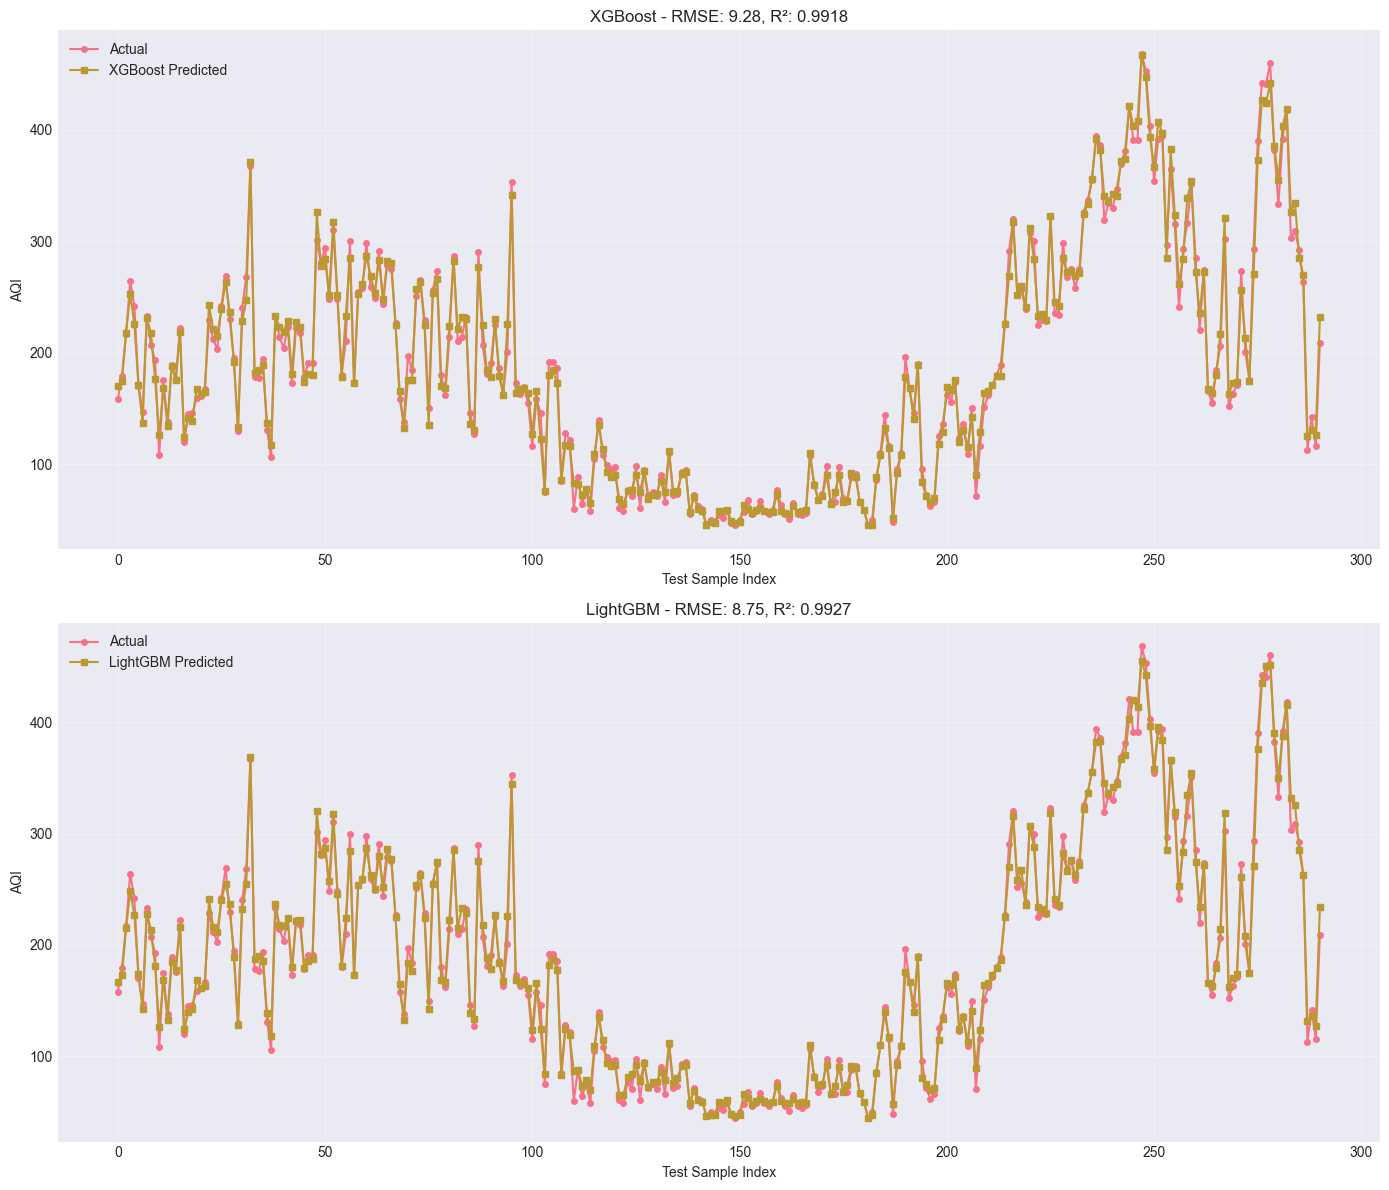

In [11]:
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

comparison_df = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM'],
    'RMSE': [xgb_rmse, lgb_rmse],
    'MAE': [xgb_mae, lgb_mae],
    'R² Score': [xgb_r2, lgb_r2]
})

print(comparison_df.to_string(index=False))

# ============================================
# Visualization
# ============================================
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# XGBoost
axes[0].plot(y_test.values, label='Actual', marker='o', markersize=4)
axes[0].plot(xgb_pred, label='XGBoost Predicted', marker='s', markersize=4)
axes[0].set_title(f'XGBoost - RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.4f}')
axes[0].set_xlabel('Test Sample Index')
axes[0].set_ylabel(target_variable)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# LightGBM
axes[1].plot(y_test.values, label='Actual', marker='o', markersize=4)
axes[1].plot(lgb_pred, label='LightGBM Predicted', marker='s', markersize=4)
axes[1].set_title(f'LightGBM - RMSE: {lgb_rmse:.2f}, R²: {lgb_r2:.4f}')
axes[1].set_xlabel('Test Sample Index')
axes[1].set_ylabel(target_variable)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'model_comparison.png'")
plt.show()

### Sequential Based Deep Learning Models

In [12]:
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Define features and target
feature_columns = [
    # Original pollutants (MUST HAVE)
    'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Ozone',
    
    # Temporal features (helps capture seasonality)
    'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos',
    'Is_Weekend', 'Holidays_Count',
    
    # Recent lag features (captures immediate history)
    'PM2.5_lag1', 'PM2.5_lag2', 'PM2.5_lag3',
    'PM10_lag1', 'PM10_lag2', 'PM10_lag3',
    'NO2_lag1', 'NO2_lag2', 'NO2_lag3',
    'AQI_lag1', 'AQI_lag2', 'AQI_lag3',
    
    # Rolling statistics (smoothed trends)
    'PM2.5_roll3_mean', 'PM2.5_roll7_mean',
    'PM10_roll3_mean', 'PM10_roll7_mean',
    'NO2_roll3_mean', 'NO2_roll7_mean',
    'AQI_roll3_mean', 'AQI_roll7_mean',
    
    # Volatility indicators
    'PM2.5_roll3_std', 'PM10_roll3_std',
    
    # Rate of change (momentum)
    'PM2.5_diff1', 'PM10_diff1', 'NO2_diff1',
    
    # Key interactions
    'PM2.5_to_PM10_ratio', 'PM_total'
]
target_variable = 'AQI'

# Extract features and target
data = df[feature_columns + [target_variable]].values

print(f"\nTotal samples: {len(data)}")
print(f"Features: {feature_columns}")
print(f"Target: {target_variable}")

# ============================================
# Data Preparation for LSTM/GRU
# ============================================

# Normalize the data
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

scaled_features = scaler_features.fit_transform(df[feature_columns])
scaled_target = scaler_target.fit_transform(df[[target_variable]])

# Combine scaled data
scaled_data = np.hstack([scaled_features, scaled_target])

# Create sequences for time series
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])  # All features
        y.append(data[i+seq_length, -1])      # Target (AQI)
    return np.array(X), np.array(y)

# Sequence length (lookback window)
seq_length = 10  # Use past 10 days to predict next day (increased for better patterns)

X, y = create_sequences(scaled_data, seq_length)

print(f"\nSequence shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Train-test split (80-20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Input shape: (samples, timesteps, features) = ({X_train.shape[0]}, {X_train.shape[1]}, {X_train.shape[2]})")

Dataset shape: (1454, 115)

First few rows:
   Month  Year  Holidays_Count  Days   PM2.5    PM10     NO2    SO2    CO  \
0      1  2021               0     5  140.05  184.29  102.61  10.34  0.79   
1      1  2021               0     6  144.01  192.43  108.43  10.41  0.85   
2      1  2021               1     7  131.57  180.38   93.31   9.92  0.69   
3      1  2021               0     1  135.92  208.99  105.07  10.49  0.75   
4      1  2021               0     2  172.48  220.74  111.52  10.21  0.91   

   Ozone  ...  PM2.5_ema7   PM10_ema3   PM10_ema7    NO2_ema3    NO2_ema7  \
0  43.06  ...  177.774019  166.637891  210.547432  110.678125  123.308271   
1  42.23  ...  169.333014  179.533945  206.018074  109.554063  119.588704   
2  51.96  ...  159.892260  179.956973  199.608556  101.432031  113.019028   
3  55.06  ...  153.899195  194.473486  201.953917  103.251016  111.031771   
4  41.69  ...  158.544396  207.606743  206.650438  107.385508  111.153828   

     AQI_ema3    AQI_ema7  AQI

In [13]:
# ============================================
# LSTM Model
# ============================================
lstm_model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(seq_length, len(feature_columns))),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print("\nLSTM Model Architecture:")
lstm_model.summary()

# Early stopping with more patience
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Train LSTM
print("\nTraining LSTM...")
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Predict
lstm_pred_scaled = lstm_model.predict(X_test)
lstm_pred = scaler_target.inverse_transform(lstm_pred_scaled)
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# LSTM Metrics
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_pred))
lstm_mae = mean_absolute_error(y_test_actual, lstm_pred)
lstm_r2 = r2_score(y_test_actual, lstm_pred)

print(f"\nLSTM Results:")
print(f"RMSE: {lstm_rmse:.2f}")
print(f"MAE: {lstm_mae:.2f}")
print(f"R² Score: {lstm_r2:.4f}")


LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 128)             │          86,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 10, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 148,385 (579.63 KB)

 Trainable params: 148,385 (579.63 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM...
Epoch 1/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0921 - mae: 0.2342 - val_loss: 0.0253 - val_mae: 0.1210
Epoch 2/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0272 - mae: 0.1317 - val_loss: 0.0245 - val_mae: 0.1212
Epoch 3/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0242 - mae: 0.1196 - val_loss: 0.0239 - val_mae: 0.1192
Epoch 4/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0252 - mae: 0.1228 - val_loss: 0.0235 - val_mae: 0.1178
Epoch 5/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0238 - mae: 0.1199 - val_loss: 0.0234 - val_mae: 0.1177
Epoch 6/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0228 - mae: 0.1171 - val_loss: 0.0227 - val_mae: 0.1154
Epoch 7/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0229 - mae: 0.1168 - val_loss: 0.0225 - val_mae: 0.1152
Epoch 8/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0233 - mae: 0.1175 - val_loss: 0.0244 - val_mae: 0.1205
Epoch 9/300
15/15 ━━━━━━━━━━━━━━━━━━━━

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0122 - mae: 0.0845 - val_loss: 0.0130 - val_mae: 0.0886
Epoch 55/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0127 - mae: 0.0855 - val_loss: 0.0119 - val_mae: 0.0852
Epoch 56/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0115 - mae: 0.0818 - val_loss: 0.0129 - val_mae: 0.0866
Epoch 57/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0120 - mae: 0.0842 - val_loss: 0.0128 - val_mae: 0.0884
Epoch 58/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0098 - mae: 0.0763 - val_loss: 0.0113 - val_mae: 0.0806
Epoch 59/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0111 - mae: 0.0823 - val_loss: 0.0117 - val_mae: 0.0834
Epoch 60/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0119 - mae: 0.0835 - val_loss: 0.0126 - val_mae: 0.0870
Epoch 61/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0108 - mae: 0.0817 - val_loss: 0.0108 - val_mae: 0.0811
Epoch 62/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0091 - mae: 0.0717 - val_loss: 0.0136 - val_mae: 0.0899
Epoch 108/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0091 - mae: 0.0724 - val_loss: 0.0107 - val_mae: 0.0753
Epoch 109/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0086 - mae: 0.0713 - val_loss: 0.0123 - val_mae: 0.0836
Epoch 110/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0087 - mae: 0.0708 - val_loss: 0.0145 - val_mae: 0.0908
Epoch 111/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0086 - mae: 0.0703 - val_loss: 0.0125 - val_mae: 0.0842
Epoch 112/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0075 - mae: 0.0660 - val_loss: 0.0118 - val_mae: 0.0810
Epoch 113/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0097 - mae: 0.0753 - val_loss: 0.0130 - val_mae: 0.0853
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step

LSTM Results:
RMSE: 48.95
MAE: 38.39
R² Score: 0.7737


In [14]:
# ============================================
# GRU Model
# ============================================

gru_model = Sequential([
    GRU(128, activation='tanh', return_sequences=True, input_shape=(seq_length, len(feature_columns))),
    Dropout(0.3),
    GRU(64, activation='tanh', return_sequences=True),
    Dropout(0.3),
    GRU(32, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

gru_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print("\nGRU Model Architecture:")
gru_model.summary()

# Train GRU
print("\nTraining GRU...")
gru_history = gru_model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Predict
gru_pred_scaled = gru_model.predict(X_test)
gru_pred = scaler_target.inverse_transform(gru_pred_scaled)

# GRU Metrics
gru_rmse = np.sqrt(mean_squared_error(y_test_actual, gru_pred))
gru_mae = mean_absolute_error(y_test_actual, gru_pred)
gru_r2 = r2_score(y_test_actual, gru_pred)

print(f"\nGRU Results:")
print(f"RMSE: {gru_rmse:.2f}")
print(f"MAE: {gru_mae:.2f}")
print(f"R² Score: {gru_r2:.4f}")



GRU Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 10, 128)             │          64,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 10, 64)              │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,153 (442.00 KB)

 Trainable params: 113,153 (442.00 KB)

 Non-trainable params: 0 (0.00 B)


Training GRU...
Epoch 1/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0666 - mae: 0.1998 - val_loss: 0.0234 - val_mae: 0.1188
Epoch 2/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0267 - mae: 0.1291 - val_loss: 0.0254 - val_mae: 0.1185
Epoch 3/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0256 - mae: 0.1238 - val_loss: 0.0207 - val_mae: 0.1082
Epoch 4/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0210 - mae: 0.1140 - val_loss: 0.0209 - val_mae: 0.1085
Epoch 5/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0219 - mae: 0.1169 - val_loss: 0.0193 - val_mae: 0.1036
Epoch 6/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0199 - mae: 0.1084 - val_loss: 0.0196 - val_mae: 0.1043
Epoch 7/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0188 - mae: 0.1048 - val_loss: 0.0195 - val_mae: 0.1037
Epoch 8/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0188 - mae: 0.1074 - val_loss: 0.0188 - val_mae: 0.1021
Epoch 9/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0115 - mae: 0.0819 - val_loss: 0.0125 - val_mae: 0.0832
Epoch 55/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0114 - mae: 0.0833 - val_loss: 0.0101 - val_mae: 0.0728
Epoch 56/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0102 - mae: 0.0783 - val_loss: 0.0109 - val_mae: 0.0769
Epoch 57/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0097 - mae: 0.0756 - val_loss: 0.0116 - val_mae: 0.0785
Epoch 58/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0107 - mae: 0.0786 - val_loss: 0.0109 - val_mae: 0.0778
Epoch 59/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0098 - mae: 0.0740 - val_loss: 0.0101 - val_mae: 0.0736
Epoch 60/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0091 - mae: 0.0730 - val_loss: 0.0098 - val_mae: 0.0742
Epoch 61/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0107 - mae: 0.0785 - val_loss: 0.0105 - val_mae: 0.0748
Epoch 62/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 


MODEL COMPARISON
Model      RMSE       MAE  R² Score
 LSTM 48.945484 38.393098  0.773704
  GRU 45.141214 33.792813  0.807515

🏆 Best Model: GRU (Lowest RMSE)

Training history saved as 'training_history.png'


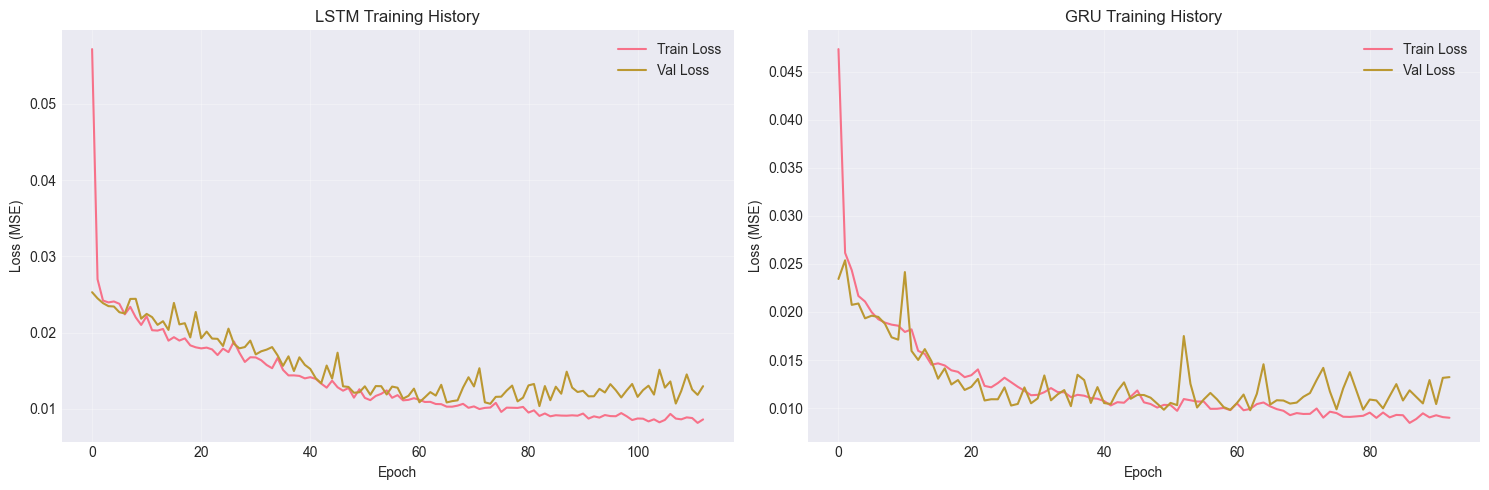

Predictions comparison saved as 'predictions_comparison.png'


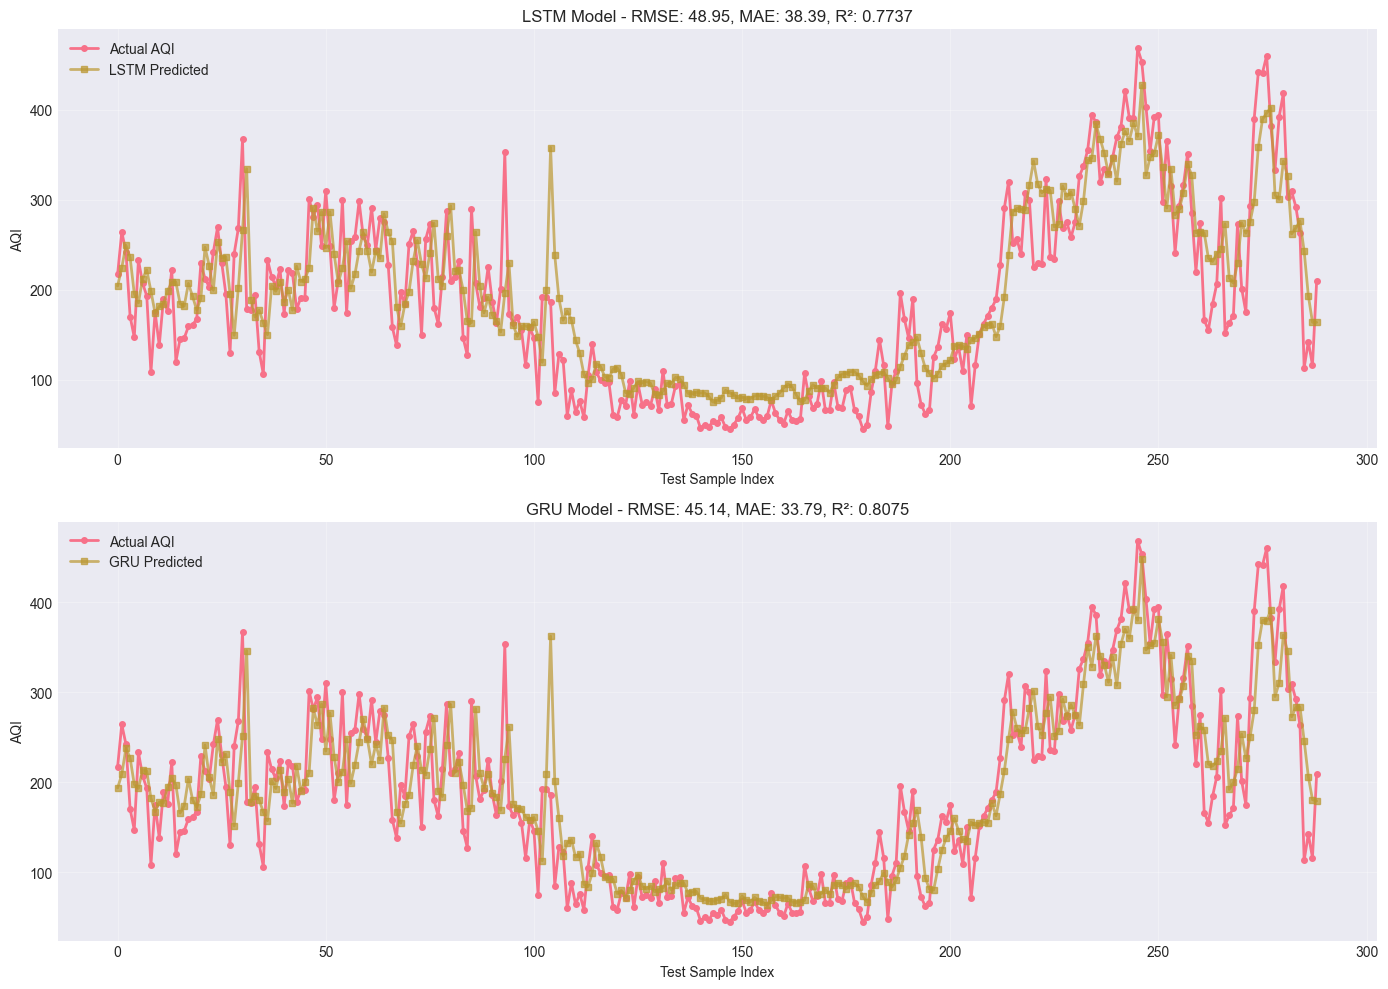

Scatter comparison saved as 'scatter_comparison.png'


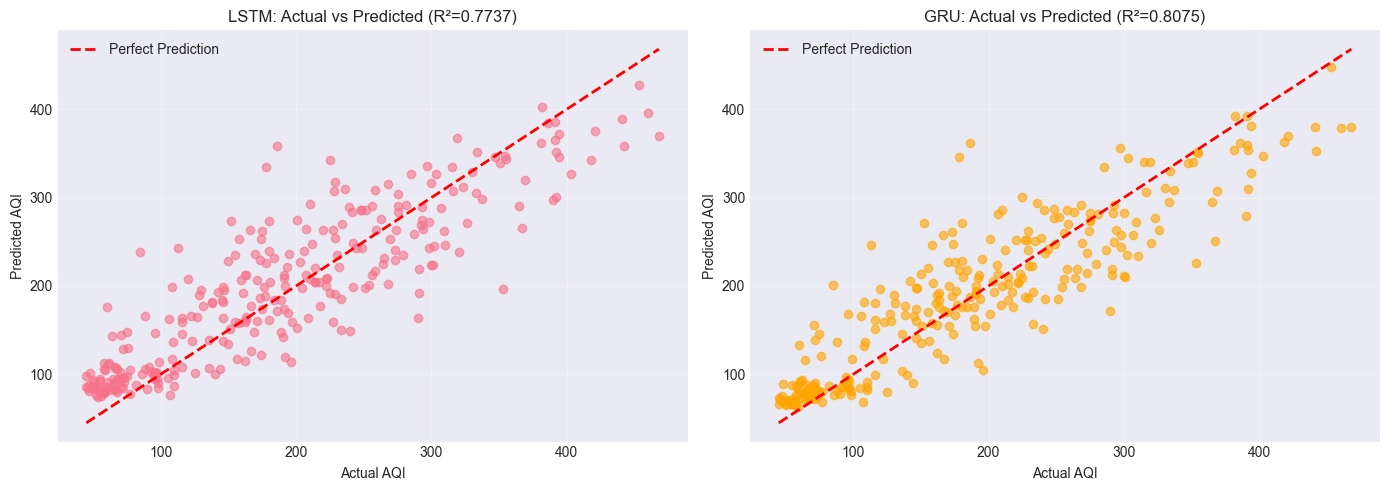


✅ Models saved as 'lstm_air_quality_model.h5' and 'gru_air_quality_model.h5'


In [15]:
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

comparison_df = pd.DataFrame({
    'Model': ['LSTM', 'GRU'],
    'RMSE': [lstm_rmse, gru_rmse],
    'MAE': [lstm_mae, gru_mae],
    'R² Score': [lstm_r2, gru_r2]
})

print(comparison_df.to_string(index=False))

# Find best model
best_model_idx = comparison_df['RMSE'].idxmin()
best_model = comparison_df.loc[best_model_idx, 'Model']
print(f"\n🏆 Best Model: {best_model} (Lowest RMSE)")

# ============================================
# Visualization
# ============================================

# 1. Training History
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# LSTM Training History
axes[0].plot(lstm_history.history['loss'], label='Train Loss')
axes[0].plot(lstm_history.history['val_loss'], label='Val Loss')
axes[0].set_title('LSTM Training History')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# GRU Training History
axes[1].plot(gru_history.history['loss'], label='Train Loss')
axes[1].plot(gru_history.history['val_loss'], label='Val Loss')
axes[1].set_title('GRU Training History')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss (MSE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
print("\nTraining history saved as 'training_history.png'")
plt.show()

# 2. Predictions Comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# LSTM Predictions
axes[0].plot(y_test_actual, label='Actual AQI', marker='o', markersize=4, linewidth=2)
axes[0].plot(lstm_pred, label='LSTM Predicted', marker='s', markersize=4, linewidth=2, alpha=0.7)
axes[0].set_title(f'LSTM Model - RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}, R²: {lstm_r2:.4f}')
axes[0].set_xlabel('Test Sample Index')
axes[0].set_ylabel('AQI')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# GRU Predictions
axes[1].plot(y_test_actual, label='Actual AQI', marker='o', markersize=4, linewidth=2)
axes[1].plot(gru_pred, label='GRU Predicted', marker='s', markersize=4, linewidth=2, alpha=0.7)
axes[1].set_title(f'GRU Model - RMSE: {gru_rmse:.2f}, MAE: {gru_mae:.2f}, R²: {gru_r2:.4f}')
axes[1].set_xlabel('Test Sample Index')
axes[1].set_ylabel('AQI')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('predictions_comparison.png', dpi=300, bbox_inches='tight')
print("Predictions comparison saved as 'predictions_comparison.png'")
plt.show()

# 3. Scatter Plot (Actual vs Predicted)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LSTM Scatter
axes[0].scatter(y_test_actual, lstm_pred, alpha=0.6)
axes[0].plot([y_test_actual.min(), y_test_actual.max()], 
             [y_test_actual.min(), y_test_actual.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual AQI')
axes[0].set_ylabel('Predicted AQI')
axes[0].set_title(f'LSTM: Actual vs Predicted (R²={lstm_r2:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# GRU Scatter
axes[1].scatter(y_test_actual, gru_pred, alpha=0.6, color='orange')
axes[1].plot([y_test_actual.min(), y_test_actual.max()], 
             [y_test_actual.min(), y_test_actual.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual AQI')
axes[1].set_ylabel('Predicted AQI')
axes[1].set_title(f'GRU: Actual vs Predicted (R²={gru_r2:.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('scatter_comparison.png', dpi=300, bbox_inches='tight')
print("Scatter comparison saved as 'scatter_comparison.png'")
plt.show()

# ============================================
# Save Models
# ============================================
lstm_model.save('lstm_air_quality_model.h5')
gru_model.save('gru_air_quality_model.h5')
print("\n✅ Models saved as 'lstm_air_quality_model.h5' and 'gru_air_quality_model.h5'")

### Statistical Time Series Analysis

   Month  Year  Holidays_Count  Days   PM2.5    PM10     NO2    SO2    CO  \
0      1  2021               0     5  140.05  184.29  102.61  10.34  0.79   
1      1  2021               0     6  144.01  192.43  108.43  10.41  0.85   
2      1  2021               1     7  131.57  180.38   93.31   9.92  0.69   
3      1  2021               0     1  135.92  208.99  105.07  10.49  0.75   
4      1  2021               0     2  172.48  220.74  111.52  10.21  0.91   
5      1  2021               0     3  224.71  330.04  125.83   7.27  1.22   
6      1  2021               0     4  345.82  417.42  142.59   8.49  1.75   
7      1  2021               0     5  462.62  517.76  178.15  10.11  2.51   
8      1  2021               0     6  185.66  230.76  124.98   7.39  1.65   
9      1  2021               1     7  222.01  249.23  136.15   9.56  1.40   

   Ozone  ...  PM2.5_ema7   PM10_ema3   PM10_ema7    NO2_ema3    NO2_ema7  \
0  43.06  ...  177.774019  166.637891  210.547432  110.678125  123.308271  

C:\Users\koush\AppData\Local\Temp\ipykernel_9560\1385177882.py:103: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(timeseries, regression='c', nlags='auto')
C:\Users\koush\AppData\Local\Temp\ipykernel_9560\1385177882.py:103: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(timeseries, regression='c', nlags='auto')
C:\Users\koush\AppData\Local\Temp\ipykernel_9560\1385177882.py:103: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(timeseries, regression='c', nlags='auto')


✅ Seasonal decomposition saved as 'seasonal_decomposition.png'


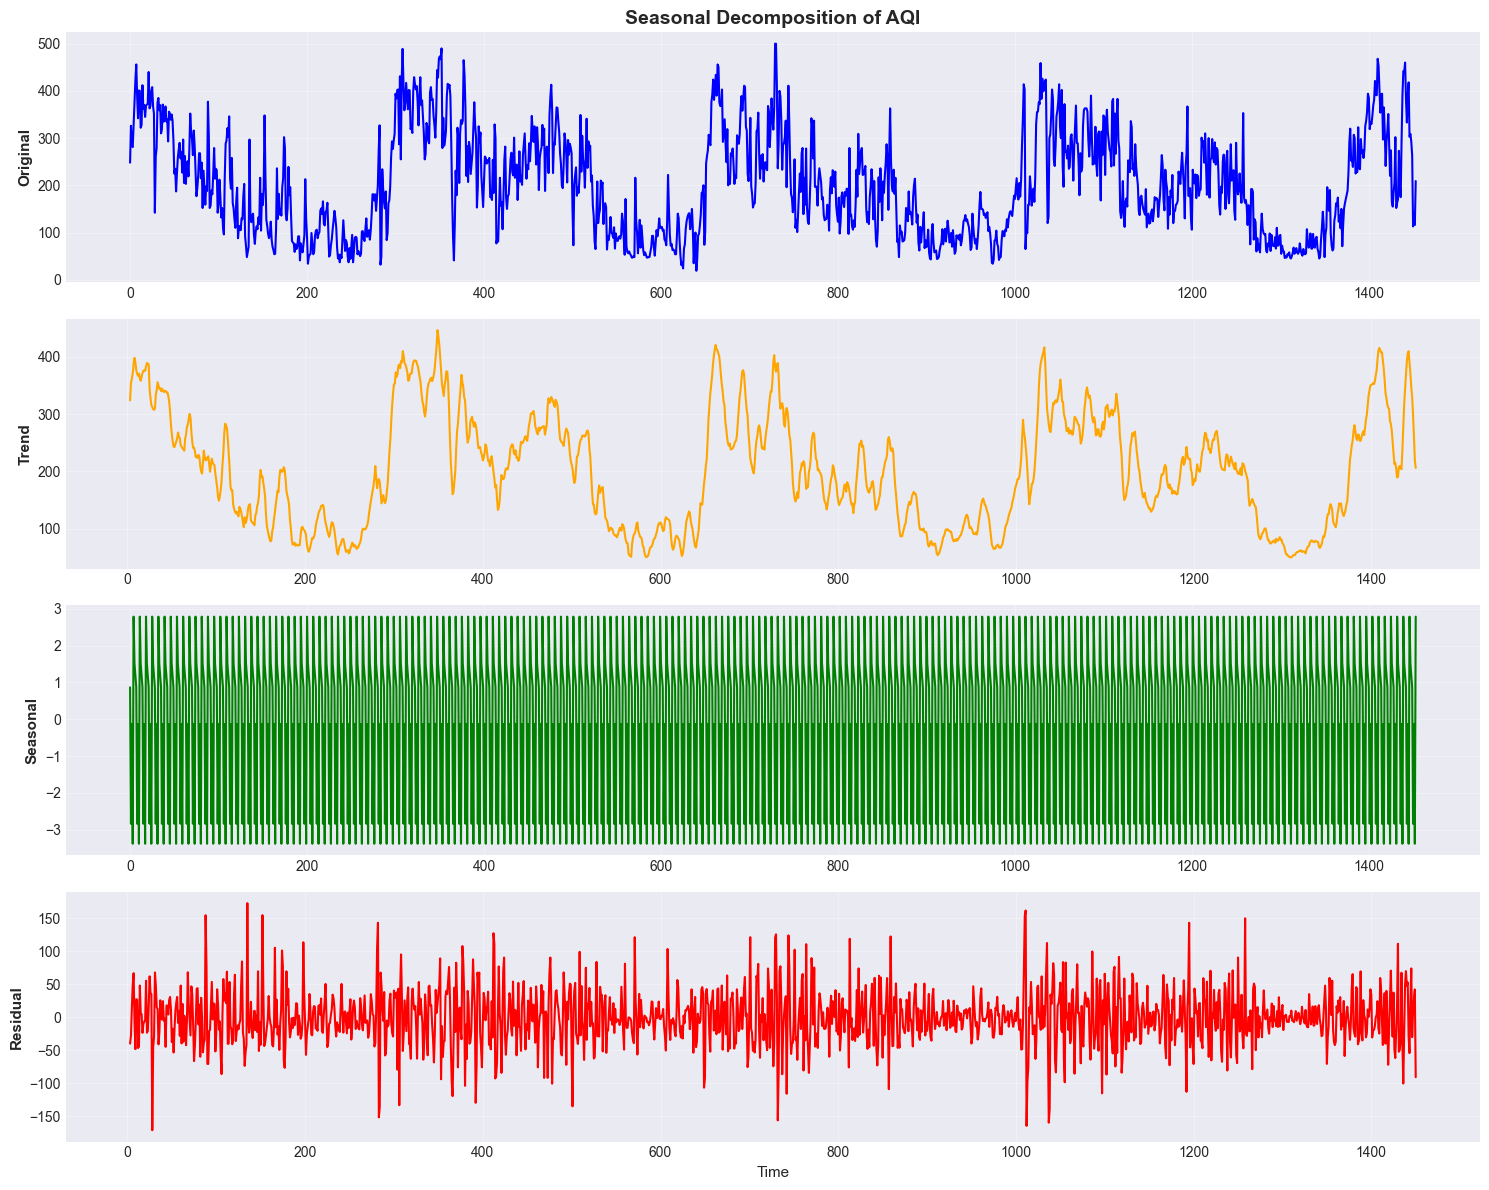


📈 Seasonality Strength: 0.0026
   → Weak/No seasonality detected (Use ARIMA)

3. AUTOCORRELATION ANALYSIS (ACF & PACF)

✅ ACF and PACF plots saved as 'acf_pacf_plots.png'


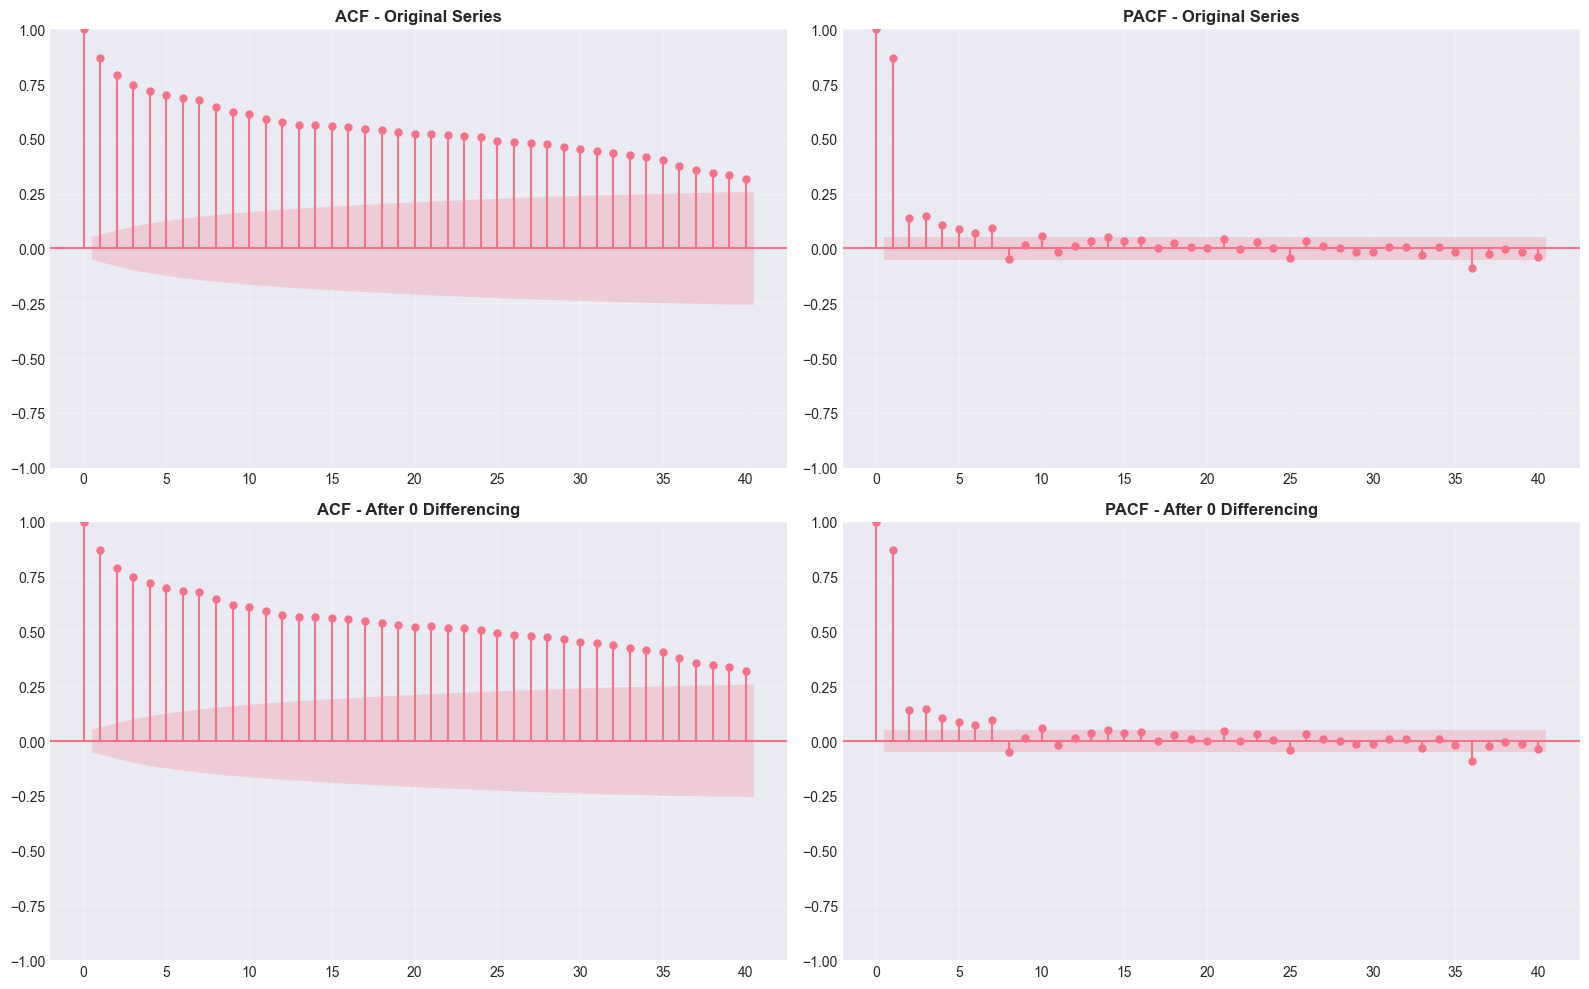


📊 Significant ACF lags: [1 2 3 4 5]
📊 Significant PACF lags: [1 2 3 4 5]

🎯 Suggested p (AR order) from PACF: 1
🎯 Suggested q (MA order) from ACF: 1
🎯 Determined d (Differencing): 0


In [16]:
print(df.head(10))

# Define features and target
feature_columns = [
    # Original pollutants
    'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Ozone',
    
    # Temporal features
    'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 
    'Quarter', 'Season', 'Is_Weekend', 'Holidays_Count',
    
    # Lag features (1, 2, 3, 7 days)
    'PM2.5_lag1', 'PM2.5_lag2', 'PM2.5_lag3', 'PM2.5_lag7',
    'PM10_lag1', 'PM10_lag2', 'PM10_lag3', 'PM10_lag7',
    'NO2_lag1', 'NO2_lag2', 'NO2_lag3', 'NO2_lag7',
    'SO2_lag1', 'SO2_lag2', 'SO2_lag3', 'SO2_lag7',
    'CO_lag1', 'CO_lag2', 'CO_lag3', 'CO_lag7',
    'Ozone_lag1', 'Ozone_lag2', 'Ozone_lag3', 'Ozone_lag7',
    'AQI_lag1', 'AQI_lag2', 'AQI_lag3', 'AQI_lag7',
    
    # Rolling statistics (3-day and 7-day)
    'PM2.5_roll3_mean', 'PM2.5_roll7_mean', 'PM2.5_roll3_std',
    'PM2.5_roll7_min', 'PM2.5_roll7_max',
    'PM10_roll3_mean', 'PM10_roll7_mean', 'PM10_roll3_std',
    'PM10_roll7_min', 'PM10_roll7_max',
    'NO2_roll3_mean', 'NO2_roll7_mean', 'NO2_roll3_std',
    'NO2_roll7_min', 'NO2_roll7_max',
    'SO2_roll3_mean', 'SO2_roll7_mean', 'SO2_roll3_std',
    'SO2_roll7_min', 'SO2_roll7_max',
    'CO_roll3_mean', 'CO_roll7_mean', 'CO_roll3_std',
    'CO_roll7_min', 'CO_roll7_max',
    'Ozone_roll3_mean', 'Ozone_roll7_mean', 'Ozone_roll3_std',
    'Ozone_roll7_min', 'Ozone_roll7_max',
    'AQI_roll3_mean', 'AQI_roll7_mean', 'AQI_roll3_std',
    'AQI_roll7_min', 'AQI_roll7_max',
    
    # Rate of change
    'PM2.5_diff1', 'PM2.5_pct_change',
    'PM10_diff1', 'PM10_pct_change',
    'NO2_diff1', 'NO2_pct_change',
    'SO2_diff1', 'SO2_pct_change',
    'CO_diff1', 'CO_pct_change',
    'Ozone_diff1', 'Ozone_pct_change',
    'AQI_diff1', 'AQI_pct_change',
    
    # Interaction features
    'PM2.5_to_PM10_ratio', 'PM_total', 'Gas_total',
    'PM2.5_NO2_interaction', 'Holiday_PM2.5',
    
    # Statistical features
    'Pollutants_Mean', 'Pollutants_Std', 'Pollutants_Max', 'Pollutants_Min',
    
    # Exponential moving averages
    'PM2.5_ema3', 'PM2.5_ema7',
    'PM10_ema3', 'PM10_ema7',
    'NO2_ema3', 'NO2_ema7',
    'AQI_ema3', 'AQI_ema7',
    
    # Domain-specific
    'AQI_Category', 'PM2.5_Dominant', 'High_Pollution_Day'
]
target_variable = 'AQI'

# Extract time series
ts_data = df[target_variable].values
print(f"\nAnalyzing target variable: {target_variable}")
print(f"Time series length: {len(ts_data)}")
print(f"Mean: {ts_data.mean():.2f}, Std: {ts_data.std():.2f}")
print(f"Min: {ts_data.min():.2f}, Max: {ts_data.max():.2f}")

# ============================================
# 1. STATIONARITY TESTS
# ============================================
print("\n" + "="*70)
print("1. STATIONARITY TESTS")
print("="*70)

def adf_test(timeseries, variable_name):
    """Augmented Dickey-Fuller Test"""
    print(f"\n📊 ADF Test Results for {variable_name}:")
    print("-" * 50)
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print(f'\n✅ Result: Series is STATIONARY (p-value = {result[1]:.6f} <= 0.05)')
        print('   → Reject null hypothesis: No unit root present')
    else:
        print(f'\n❌ Result: Series is NON-STATIONARY (p-value = {result[1]:.6f} > 0.05)')
        print('   → Fail to reject null hypothesis: Unit root present')
        print('   → Differencing is required')
    
    return result[1] <= 0.05

def kpss_test(timeseries, variable_name):
    """KPSS Test"""
    print(f"\n📊 KPSS Test Results for {variable_name}:")
    print("-" * 50)
    result = kpss(timeseries, regression='c', nlags='auto')
    print(f'KPSS Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[3].items():
        print(f'   {key}: {value:.3f}')
    
    if result[1] >= 0.05:
        print(f'\n✅ Result: Series is STATIONARY (p-value = {result[1]:.6f} >= 0.05)')
        print('   → Fail to reject null hypothesis: Series is stationary')
    else:
        print(f'\n❌ Result: Series is NON-STATIONARY (p-value = {result[1]:.6f} < 0.05)')
        print('   → Reject null hypothesis: Series is not stationary')
        print('   → Differencing is required')
    
    return result[1] >= 0.05

# Test original series
print("\n" + "─" * 70)
print("ORIGINAL SERIES TESTS")
print("─" * 70)
adf_stationary = adf_test(ts_data, target_variable)
kpss_stationary = kpss_test(ts_data, target_variable)

# Test first difference
print("\n" + "─" * 70)
print("FIRST DIFFERENCE TESTS")
print("─" * 70)
ts_diff1 = np.diff(ts_data)
adf_diff1 = adf_test(ts_diff1, f"{target_variable} (1st Difference)")
kpss_diff1 = kpss_test(ts_diff1, f"{target_variable} (1st Difference)")

# Test second difference if needed
print("\n" + "─" * 70)
print("SECOND DIFFERENCE TESTS")
print("─" * 70)
ts_diff2 = np.diff(ts_diff1)
adf_diff2 = adf_test(ts_diff2, f"{target_variable} (2nd Difference)")
kpss_diff2 = kpss_test(ts_diff2, f"{target_variable} (2nd Difference)")

# Determine d value
if adf_stationary and kpss_stationary:
    d_value = 0
    print("\n🎯 Recommended d value: 0 (Series is already stationary)")
elif adf_diff1 and kpss_diff1:
    d_value = 1
    print("\n🎯 Recommended d value: 1 (First difference makes series stationary)")
else:
    d_value = 2
    print("\n🎯 Recommended d value: 2 (Second difference required)")

# ============================================
# 2. SEASONALITY TESTS
# ============================================
print("\n" + "="*70)
print("2. SEASONALITY ANALYSIS")
print("="*70)

# Seasonal decomposition
print("\nPerforming seasonal decomposition...")
decomposition = seasonal_decompose(ts_data, model='additive', period=7)  # Weekly seasonality

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

axes[0].plot(ts_data, color='blue', linewidth=1.5)
axes[0].set_ylabel('Original', fontsize=11, fontweight='bold')
axes[0].set_title(f'Seasonal Decomposition of {target_variable}', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(decomposition.trend, color='orange', linewidth=1.5)
axes[1].set_ylabel('Trend', fontsize=11, fontweight='bold')
axes[1].grid(True, alpha=0.3)

axes[2].plot(decomposition.seasonal, color='green', linewidth=1.5)
axes[2].set_ylabel('Seasonal', fontsize=11, fontweight='bold')
axes[2].grid(True, alpha=0.3)

axes[3].plot(decomposition.resid, color='red', linewidth=1.5)
axes[3].set_ylabel('Residual', fontsize=11, fontweight='bold')
axes[3].set_xlabel('Time', fontsize=11)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('seasonal_decomposition.png', dpi=300, bbox_inches='tight')
print("✅ Seasonal decomposition saved as 'seasonal_decomposition.png'")
plt.show()

# Check seasonality strength
seasonal_component = decomposition.seasonal[~np.isnan(decomposition.seasonal)]
residual_component = decomposition.resid[~np.isnan(decomposition.resid)]
seasonal_strength = np.var(seasonal_component) / np.var(residual_component)
print(f"\n📈 Seasonality Strength: {seasonal_strength:.4f}")
if seasonal_strength > 0.64:
    print("   → Strong seasonality detected (Use SARIMA/SARIMAX)")
    seasonal = True
    seasonal_period = 7
elif seasonal_strength > 0.1:
    print("   → Moderate seasonality detected (Consider SARIMA/SARIMAX)")
    seasonal = True
    seasonal_period = 7
else:
    print("   → Weak/No seasonality detected (Use ARIMA)")
    seasonal = False
    seasonal_period = 0

# ============================================
# 3. ACF AND PACF PLOTS
# ============================================
print("\n" + "="*70)
print("3. AUTOCORRELATION ANALYSIS (ACF & PACF)")
print("="*70)

# Plot ACF and PACF for original series
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Original series
plot_acf(ts_data, lags=40, ax=axes[0, 0])
axes[0, 0].set_title('ACF - Original Series', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

plot_pacf(ts_data, lags=40, ax=axes[0, 1])
axes[0, 1].set_title('PACF - Original Series', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Differenced series
ts_for_acf = ts_diff1 if d_value >= 1 else ts_data
plot_acf(ts_for_acf, lags=40, ax=axes[1, 0])
axes[1, 0].set_title(f'ACF - After {d_value} Differencing', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

plot_pacf(ts_for_acf, lags=40, ax=axes[1, 1])
axes[1, 1].set_title(f'PACF - After {d_value} Differencing', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('acf_pacf_plots.png', dpi=300, bbox_inches='tight')
print("\n✅ ACF and PACF plots saved as 'acf_pacf_plots.png'")
plt.show()

# Analyze ACF and PACF to suggest p and q
acf_values = acf(ts_for_acf, nlags=20)
pacf_values = pacf(ts_for_acf, nlags=20)

# Find significant lags (beyond confidence interval)
confidence_interval = 1.96 / np.sqrt(len(ts_for_acf))
significant_acf = np.where(np.abs(acf_values[1:]) > confidence_interval)[0] + 1
significant_pacf = np.where(np.abs(pacf_values[1:]) > confidence_interval)[0] + 1

print(f"\n📊 Significant ACF lags: {significant_acf[:5] if len(significant_acf) > 0 else 'None'}")
print(f"📊 Significant PACF lags: {significant_pacf[:5] if len(significant_pacf) > 0 else 'None'}")

# Suggest p and q based on ACF/PACF
if len(significant_pacf) > 0:
    suggested_p = min(significant_pacf[0], 5)
else:
    suggested_p = 1

if len(significant_acf) > 0:
    suggested_q = min(significant_acf[0], 5)
else:
    suggested_q = 1

print(f"\n🎯 Suggested p (AR order) from PACF: {suggested_p}")
print(f"🎯 Suggested q (MA order) from ACF: {suggested_q}")
print(f"🎯 Determined d (Differencing): {d_value}")

In [17]:
# ============================================
# ARIMA 
# ============================================

# Split data
train_size = int(len(ts_data) * 0.8)
train, test = ts_data[:train_size], ts_data[train_size:]

print(f"\nTrain size: {len(train)}, Test size: {len(test)}")

# Define parameter ranges
p_range = range(0, 6)
d_range = range(0, 2) 
q_range = range(0, 6)

print(f"\nSearching parameters:")
print(f"p (AR): {list(p_range)}")
print(f"d (I): {list(d_range)}")
print(f"q (MA): {list(q_range)}")
print(f"\nTotal combinations: {len(p_range) * len(d_range) * len(q_range)}")

# Grid search for ARIMA
print("\n" + "─" * 70)
print("ARIMA MODEL SELECTION")
print("─" * 70)

arima_results = []
best_aic = np.inf
best_bic = np.inf
best_aic_model = None
best_bic_model = None

print("\nSearching for best ARIMA model...")
print(f"{'p':>3} {'d':>3} {'q':>3} {'AIC':>12} {'BIC':>12} {'RMSE':>10} {'Status':>20}")
print("-" * 90)

for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                # Skip invalid combinations
                if p == 0 and q == 0:  # At least one of p or q must be > 0
                    continue
                
                model = ARIMA(train, order=(p, d, q))
                fitted_model = model.fit()
                
                aic = fitted_model.aic
                bic = fitted_model.bic
                
                # ✅ IMPORTANT ADDITION: Calculate test set RMSE for validation
                forecast = fitted_model.forecast(steps=len(test))
                rmse = np.sqrt(mean_squared_error(test, forecast))
                
                arima_results.append({
                    'p': p, 'd': d, 'q': q,
                    'AIC': aic, 
                    'BIC': bic,
                    'RMSE': rmse,
                    'model': fitted_model
                })
                
                aic_status = ""
                bic_status = ""
                
                if aic < best_aic:
                    best_aic = aic
                    best_aic_model = (p, d, q)
                    aic_status = "⭐ AIC"
                
                if bic < best_bic:
                    best_bic = bic
                    best_bic_model = (p, d, q)
                    bic_status = "⭐ BIC"
                
                status = f"{aic_status:>10} {bic_status:>10}"
                print(f"{p:>3} {d:>3} {q:>3} {aic:>12.2f} {bic:>12.2f} {rmse:>10.2f} {status:>20}")
                
            except Exception as e:
                # ✅ Optional: Print which models failed (for debugging)
                # print(f"  Failed: ({p},{d},{q}) - {str(e)[:50]}")
                continue

# Check if we have any valid results
if len(arima_results) == 0:
    print("\n❌ ERROR: No valid ARIMA models found!")
    print("Try expanding parameter ranges or checking data quality.")
else:
    # Sort results by AIC and BIC separately
    arima_df = pd.DataFrame(arima_results)
    
    # ✅ IMPROVEMENT: Add RMSE ranking for model selection
    arima_df['AIC_Rank'] = arima_df['AIC'].rank()
    arima_df['BIC_Rank'] = arima_df['BIC'].rank()
    arima_df['RMSE_Rank'] = arima_df['RMSE'].rank()
    
    # ✅ IMPROVED: Consider RMSE in combined ranking
    arima_df['Combined_Rank'] = (arima_df['AIC_Rank'] + 
                                  arima_df['BIC_Rank'] + 
                                  arima_df['RMSE_Rank']) / 3
    
    arima_df = arima_df.sort_values('Combined_Rank')
    
    print("\n" + "="*90)
    print("TOP 10 ARIMA MODELS (Ranked by AIC + BIC + RMSE)")
    print("="*90)
    print(arima_df[['p', 'd', 'q', 'AIC', 'BIC', 'RMSE', 'AIC_Rank', 'BIC_Rank', 'RMSE_Rank', 'Combined_Rank']].head(10).to_string(index=False))
    
    # Determine the best overall model (lowest combined rank)
    best_overall = arima_df.iloc[0]
    best_arima = (int(best_overall['p']), int(best_overall['d']), int(best_overall['q']))
    
    # ✅ ADDITION: Also find best by RMSE (actual predictive performance)
    best_rmse_idx = arima_df['RMSE'].idxmin()
    best_rmse_model = (int(arima_df.loc[best_rmse_idx, 'p']), 
                       int(arima_df.loc[best_rmse_idx, 'd']), 
                       int(arima_df.loc[best_rmse_idx, 'q']))
    best_rmse_value = arima_df.loc[best_rmse_idx, 'RMSE']
    
    print("\n" + "="*90)
    print("BEST MODELS BY DIFFERENT CRITERIA")
    print("="*90)
    
    print(f"\n🏆 BEST BY AIC (In-sample fit): {best_aic_model}")
    print(f"   AIC: {best_aic:.2f}")
    
    print(f"\n🏆 BEST BY BIC (Parsimony): {best_bic_model}")
    print(f"   BIC: {best_bic:.2f}")
    
    print(f"\n🏆 BEST BY RMSE (Out-of-sample prediction): {best_rmse_model}")
    print(f"   RMSE: {best_rmse_value:.2f}")
    
    print(f"\n🏆 BEST OVERALL (Combined Ranking): {best_arima}")
    print(f"   AIC: {best_overall['AIC']:.2f}")
    print(f"   BIC: {best_overall['BIC']:.2f}")
    print(f"   RMSE: {best_overall['RMSE']:.2f}")
    print(f"   Combined Rank: {best_overall['Combined_Rank']:.2f}")
    
    # ✅ IMPORTANT: Check for agreement
    if best_aic_model == best_bic_model == best_rmse_model:
        best_arima = best_aic_model
        print(f"\n✅ Perfect Agreement: All criteria select {best_arima}")
    elif best_aic_model == best_bic_model:
        print(f"\n⚠️  AIC and BIC agree on {best_aic_model}, but RMSE prefers {best_rmse_model}")
        print(f"   Using combined ranking: {best_arima}")
    else:
        print(f"\n⚠️  Criteria disagree:")
        print(f"   AIC: {best_aic_model}")
        print(f"   BIC: {best_bic_model}")
        print(f"   RMSE: {best_rmse_model}")
        print(f"   Using combined ranking: {best_arima}")


Train size: 1163, Test size: 291

Searching parameters:
p (AR): [0, 1, 2, 3, 4, 5]
d (I): [0, 1]
q (MA): [0, 1, 2, 3, 4, 5]

Total combinations: 72

──────────────────────────────────────────────────────────────────────
ARIMA MODEL SELECTION
──────────────────────────────────────────────────────────────────────

Searching for best ARIMA model...
  p   d   q          AIC          BIC       RMSE               Status
------------------------------------------------------------------------------------------
  0   0   1     13367.79     13382.97     104.00      ⭐ AIC      ⭐ BIC
  0   0   2     13050.25     13070.48     103.99      ⭐ AIC      ⭐ BIC
  0   0   3     12882.53     12907.82     104.00      ⭐ AIC      ⭐ BIC
  0   0   4     12800.81     12831.16     104.04      ⭐ AIC      ⭐ BIC
  0   0   5     12741.30     12776.71     104.10      ⭐ AIC      ⭐ BIC
  0   1   1     12585.39     12595.50     111.11      ⭐ AIC      ⭐ BIC
  0   1   2     12524.77     12539.94     109.15      ⭐ AIC     

C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  2   1   5     12505.97     12546.43     107.77                      
  3   0   0     12548.87     12574.16     104.07                      
  3   0   1     12509.79     12540.14     103.81                      
  3   0   2     12509.69     12545.10     103.75                      
  3   0   3     12513.61     12554.08     103.52                      
  3   0   4     12512.81     12558.34     103.90                      


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  3   0   5     12514.88     12565.47     104.01                      
  3   1   0     12558.35     12578.58     110.35                      
  3   1   1     12504.14     12529.43     108.77                      
  3   1   2     12504.01     12534.36     108.79                      


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  3   1   3     12502.68     12538.08     108.89                      


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  3   1   4     12503.85     12544.31     109.25                      


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  3   1   5     12505.91     12551.43     108.35                      
  4   0   0     12540.13     12570.48     104.09                      
  4   0   1     12511.74     12547.15     103.77                      


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  4   0   2     12511.68     12552.15     103.75                      
  4   0   3     12513.59     12559.12     103.68                      


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  4   0   4     12511.36     12561.95     103.79                      


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  4   0   5     12517.16     12572.81     104.15                      
  4   1   0     12534.53     12559.82     109.12                      
  4   1   1     12506.13     12536.48     108.82                      
  4   1   2     12505.74     12541.14     109.03                      


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  4   1   3     12503.91     12544.38     109.22                      


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  4   1   4     12505.80     12551.32     108.35                      


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  4   1   5     12509.46     12560.04     108.21                      
  5   0   0     12524.37     12559.78     104.14                      
  5   0   1     12513.56     12554.03     103.88                      
  5   0   2     12512.90     12558.43     103.92                      


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  5   0   3     12514.88     12565.47     103.93                      


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  5   0   4     12513.90     12569.55     103.81                      


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  5   0   5     12513.93     12574.63     103.52                      
  5   1   0     12527.12     12557.47     108.96                      
  5   1   1     12505.26     12540.67     107.77                      
  5   1   2     12506.05     12546.51     108.27                      


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  5   1   3     12506.16     12551.68     108.70                      


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  5   1   4     12501.48     12552.06     108.34                      
  5   1   5     12507.90     12563.54     108.82                      

TOP 10 ARIMA MODELS (Ranked by AIC + BIC + RMSE)
 p  d  q          AIC          BIC       RMSE  AIC_Rank  BIC_Rank  RMSE_Rank  Combined_Rank
 2  0  1 12508.533467 12533.827258 103.673487      27.0       9.0        3.0      13.000000
 1  1  1 12500.766750 12515.940443 108.809790       1.0       1.0       48.0      16.666667
 2  0  2 12509.763496 12540.116045 103.810639      30.0      17.0       10.0      19.000000
 1  1  3 12504.054385 12529.343875 108.684029      11.0       5.0       43.0      19.666667
 2  1  2 12502.205525 12527.495014 108.955480       3.0       4.0       52.0      19.666667
 3  0  1 12509.785564 12540.138113 103.811456      31.0      18.0       11.0      20.000000
 3  0  2 12509.692144 12545.103452 103.752533      29.0      25.0        6.0      20.000000
 1  1  2 12502.410488 12522.642080 109.022789       4.0       2.0       

C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



ARIMA(2, 0, 1) Forecast Metrics:
   RMSE: 103.67
   MAE: 86.98
   R² Score: -0.0220
✅ ARIMA forecast plot saved as 'arima_forecast.png'


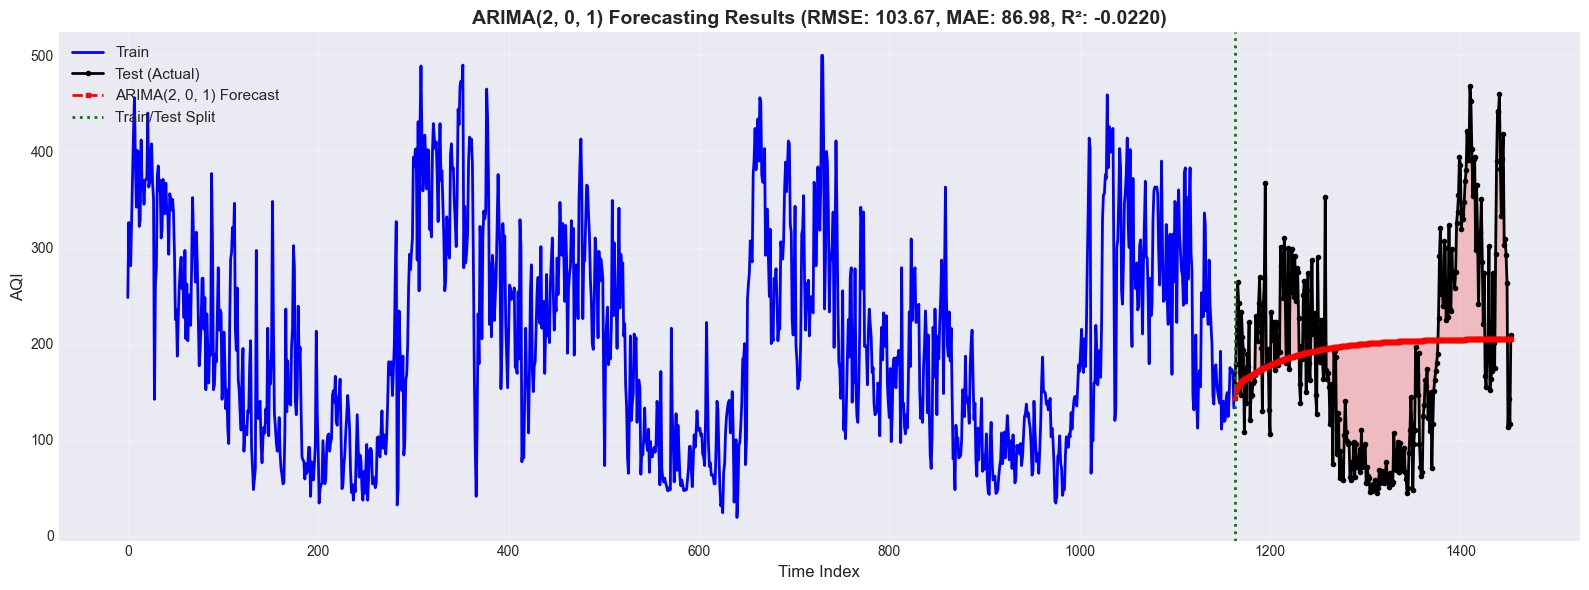

In [18]:
# ============================================
# Plot ARIMA Forecast
# ============================================
best_arima_model = arima_df.iloc[0]['model']
arima_forecast = best_arima_model.forecast(steps=len(test))

# Calculate metrics
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
arima_mae = mean_absolute_error(test, arima_forecast)
arima_r2 = r2_score(test, arima_forecast)

print(f"\nARIMA{best_arima} Forecast Metrics:")
print(f"   RMSE: {arima_rmse:.2f}")
print(f"   MAE: {arima_mae:.2f}")
print(f"   R² Score: {arima_r2:.4f}")

# Plot
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(range(len(train)), train, label='Train', linewidth=2, color='blue')
ax.plot(range(len(train), len(train) + len(test)), test, 
        label='Test (Actual)', linewidth=2, color='black', marker='o', markersize=3)
ax.plot(range(len(train), len(train) + len(test)), arima_forecast, 
        label=f'ARIMA{best_arima} Forecast', linewidth=2, linestyle='--', 
        color='red', marker='s', markersize=3)
ax.axvline(x=len(train), color='green', linestyle=':', linewidth=2, label='Train/Test Split')
ax.fill_between(range(len(train), len(train) + len(test)), test, arima_forecast, 
                alpha=0.2, color='red')
ax.set_title(f'ARIMA{best_arima} Forecasting Results (RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}, R²: {arima_r2:.4f})', 
            fontsize=14, fontweight='bold')
ax.set_xlabel('Time Index', fontsize=12)
ax.set_ylabel(target_variable, fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('arima_forecast.png', dpi=300, bbox_inches='tight')
print("✅ ARIMA forecast plot saved as 'arima_forecast.png'")
plt.show()

In [19]:
# ============================================
# SARIMAX MODEL WITH EXOGENOUS VARIABLES
# ============================================

feature_columns=[
    # Core pollutants ONLY (most important)
    'PM2.5', 'PM10', 'NO2',

    # Lagged pollutants (past values as predictors)
    'PM2.5_lag1', 'PM10_lag1', 'NO2_lag1',

    # Temporal context (minimal)
    'Month_sin', 'Month_cos',
    'Holidays_Count',

    # Rolling averages (smoothed trends)
    'PM2.5_roll3_mean', 'PM10_roll3_mean',

    # Key interaction
    'PM2.5_to_PM10_ratio'
]
# Prepare exogenous variables
exog_train = df[feature_columns][:train_size]
exog_test = df[feature_columns][train_size:]
# Fill missing values and scale
exog_train = exog_train.ffill().bfill()
exog_test = exog_test.ffill().bfill()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
exog_train_scaled = scaler.fit_transform(exog_train)
exog_test_scaled = scaler.transform(exog_test)
print(f"\nExogenous variables: {feature_columns}")
# Apply log transformation to stabilize variance
train_log = np.log1p(train)
if seasonal:
    order = best_arima
    seasonal_order = best_sarima
else:
    order = best_arima
    seasonal_order = (1, 0, 1, 7)
print(f"\nSearching for best SARIMAX model with grid search...")
print(f"Base order: {order}, Seasonal: {seasonal_order}")
sarimax_results = []
for p in range(4):
    for q in range(4):
        try:
            model = SARIMAX(
                train_log,
                exog=exog_train_scaled,
                order=(p, 0, q),
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            fitted_model = model.fit(disp=False)

            aic = fitted_model.aic
            bic = fitted_model.bic

            if np.isfinite(aic) and np.isfinite(bic):
                sarimax_results.append({
                    'order': (p, 0, q),
                    'aic': aic,
                    'bic': bic,
                    'model': fitted_model
                })
                print(f"  ({p},0,{q}) x {seasonal_order} → AIC: {aic:.2f}, BIC: {bic:.2f}")
        except:
            continue
if not sarimax_results:
    print("\n⚠️  All SARIMAX fits failed — using fallback")
    sarimax_model = SARIMAX(train_log, exog=exog_train_scaled, order=order, seasonal_order=seasonal_order)
    sarimax_fitted = sarimax_model.fit(disp=False)
    best_sarimax_order = order
else:
    # Normalize AIC and BIC then combine
    aics = np.array([r['aic'] for r in sarimax_results])
    bics = np.array([r['bic'] for r in sarimax_results])

    aic_norm = (aics - aics.min()) / (aics.max() - aics.min() + 1e-10)
    bic_norm = (bics - bics.min()) / (bics.max() - bics.min() + 1e-10)
    combined = aic_norm + bic_norm

    best_idx = np.argmin(combined)
    best_result = sarimax_results[best_idx]
    best_sarimax_order = best_result['order']
    sarimax_fitted = best_result['model']

    print(f"\n🏆 BEST SARIMAX MODEL: {best_sarimax_order} x {seasonal_order}")
    print(f"   AIC: {best_result['aic']:.2f}")
    print(f"   BIC: {best_result['bic']:.2f}")


Exogenous variables: ['PM2.5', 'PM10', 'NO2', 'PM2.5_lag1', 'PM10_lag1', 'NO2_lag1', 'Month_sin', 'Month_cos', 'Holidays_Count', 'PM2.5_roll3_mean', 'PM10_roll3_mean', 'PM2.5_to_PM10_ratio']

Searching for best SARIMAX model with grid search...
Base order: (2, 0, 1), Seasonal: (1, 0, 1, 7)
  (0,0,0) x (1, 0, 1, 7) → AIC: 148.08, BIC: 223.85


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  (0,0,1) x (1, 0, 1, 7) → AIC: -101.89, BIC: -21.08


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  (0,0,2) x (1, 0, 1, 7) → AIC: -159.80, BIC: -73.95


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  (0,0,3) x (1, 0, 1, 7) → AIC: -167.05, BIC: -76.16


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  (1,0,0) x (1, 0, 1, 7) → AIC: -183.49, BIC: -102.66


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  (1,0,1) x (1, 0, 1, 7) → AIC: -104.10, BIC: -18.23


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  (1,0,2) x (1, 0, 1, 7) → AIC: -177.93, BIC: -87.03
  (1,0,3) x (1, 0, 1, 7) → AIC: -197.72, BIC: -101.79


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  (2,0,0) x (1, 0, 1, 7) → AIC: -187.76, BIC: -101.89


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  (2,0,1) x (1, 0, 1, 7) → AIC: -187.10, BIC: -96.18
  (2,0,2) x (1, 0, 1, 7) → AIC: -183.70, BIC: -87.75


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  (2,0,3) x (1, 0, 1, 7) → AIC: -181.42, BIC: -80.43


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  (3,0,0) x (1, 0, 1, 7) → AIC: -186.43, BIC: -95.52


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  (3,0,1) x (1, 0, 1, 7) → AIC: -92.42, BIC: 3.53
  (3,0,2) x (1, 0, 1, 7) → AIC: -181.97, BIC: -80.97


C:\Users\koush\anaconda3\envs\envpy10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  (3,0,3) x (1, 0, 1, 7) → AIC: -181.10, BIC: -75.07

🏆 BEST SARIMAX MODEL: (1, 0, 3) x (1, 0, 1, 7)
   AIC: -197.72
   BIC: -101.79


SARIMAX FORECASTING
──────────────────────────────────────────────────────────────────────

SARIMAX(1, 0, 3)x(1, 0, 1, 7) Forecast Metrics:
   RMSE: 69.08
   MAE: 37.78
   R² Score: 0.5462
✅ SARIMAX forecast plot saved as 'sarimax_forecast.png'


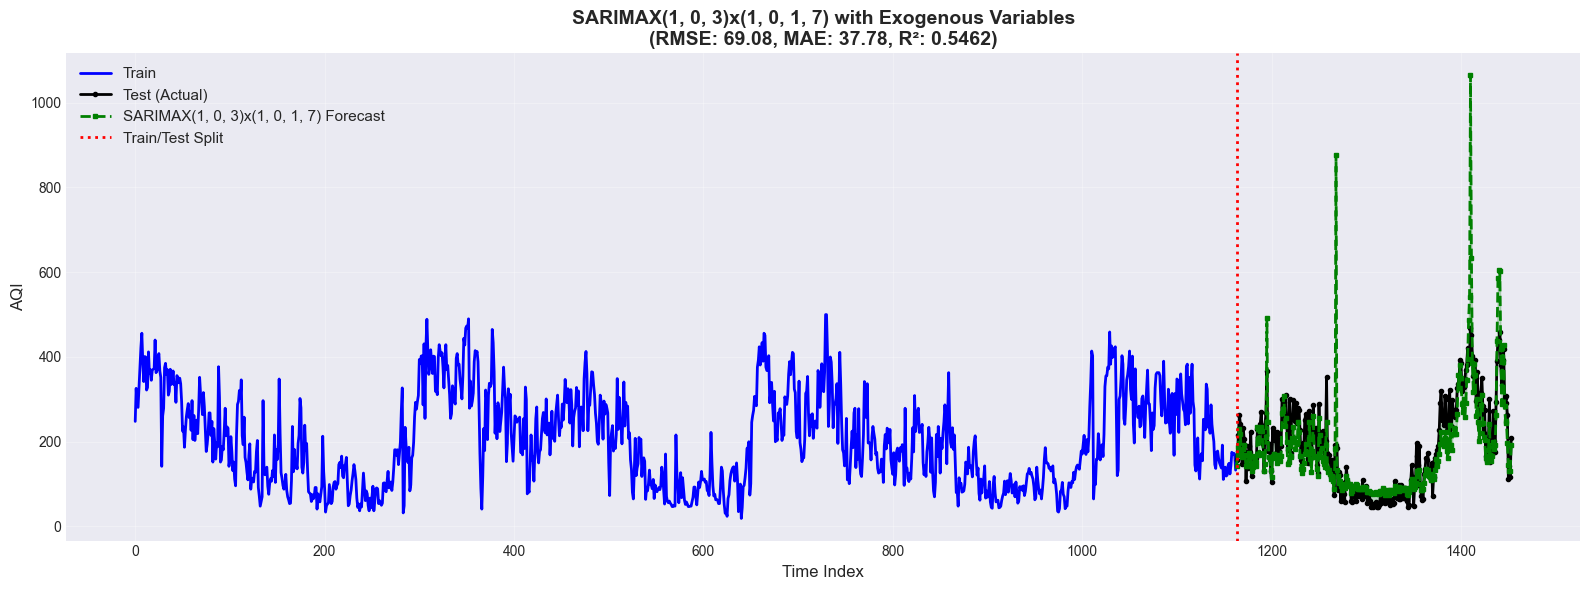

In [20]:
print("SARIMAX FORECASTING")
print("─" * 70)

# Generate forecast
sarimax_forecast_log = sarimax_fitted.forecast(steps=len(test), exog=exog_test_scaled)
sarimax_forecast = np.expm1(sarimax_forecast_log)

# Calculate metrics
sarimax_rmse = np.sqrt(mean_squared_error(test, sarimax_forecast))
sarimax_mae = mean_absolute_error(test, sarimax_forecast)
sarimax_r2 = r2_score(test, sarimax_forecast)

print(f"\nSARIMAX{best_sarimax_order}x{seasonal_order} Forecast Metrics:")
print(f"   RMSE: {sarimax_rmse:.2f}")
print(f"   MAE: {sarimax_mae:.2f}")
print(f"   R² Score: {sarimax_r2:.4f}")

# Plot
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(range(len(train)), train, label='Train', linewidth=2, color='blue')
ax.plot(range(len(train), len(train) + len(test)), test, 
        label='Test (Actual)', linewidth=2, color='black', marker='o', markersize=3)
ax.plot(range(len(train), len(train) + len(test)), sarimax_forecast, 
        label=f'SARIMAX{best_sarimax_order}x{seasonal_order} Forecast', linewidth=2, linestyle='--', 
        color='green', marker='s', markersize=3)
ax.axvline(x=len(train), color='red', linestyle=':', linewidth=2, label='Train/Test Split')
ax.fill_between(range(len(train), len(train) + len(test)), test, sarimax_forecast, 
                alpha=0.2, color='green')
ax.set_title(f'SARIMAX{best_sarimax_order}x{seasonal_order} with Exogenous Variables\n(RMSE: {sarimax_rmse:.2f}, MAE: {sarimax_mae:.2f}, R²: {sarimax_r2:.4f})', 
            fontsize=14, fontweight='bold')
ax.set_xlabel('Time Index', fontsize=12)
ax.set_ylabel(target_variable, fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('sarimax_forecast.png', dpi=300, bbox_inches='tight')
print("✅ SARIMAX forecast plot saved as 'sarimax_forecast.png'")
plt.show()


7. COMBINED FORECAST COMPARISON

✅ Combined forecast comparison saved as 'all_models_forecast_comparison.png'


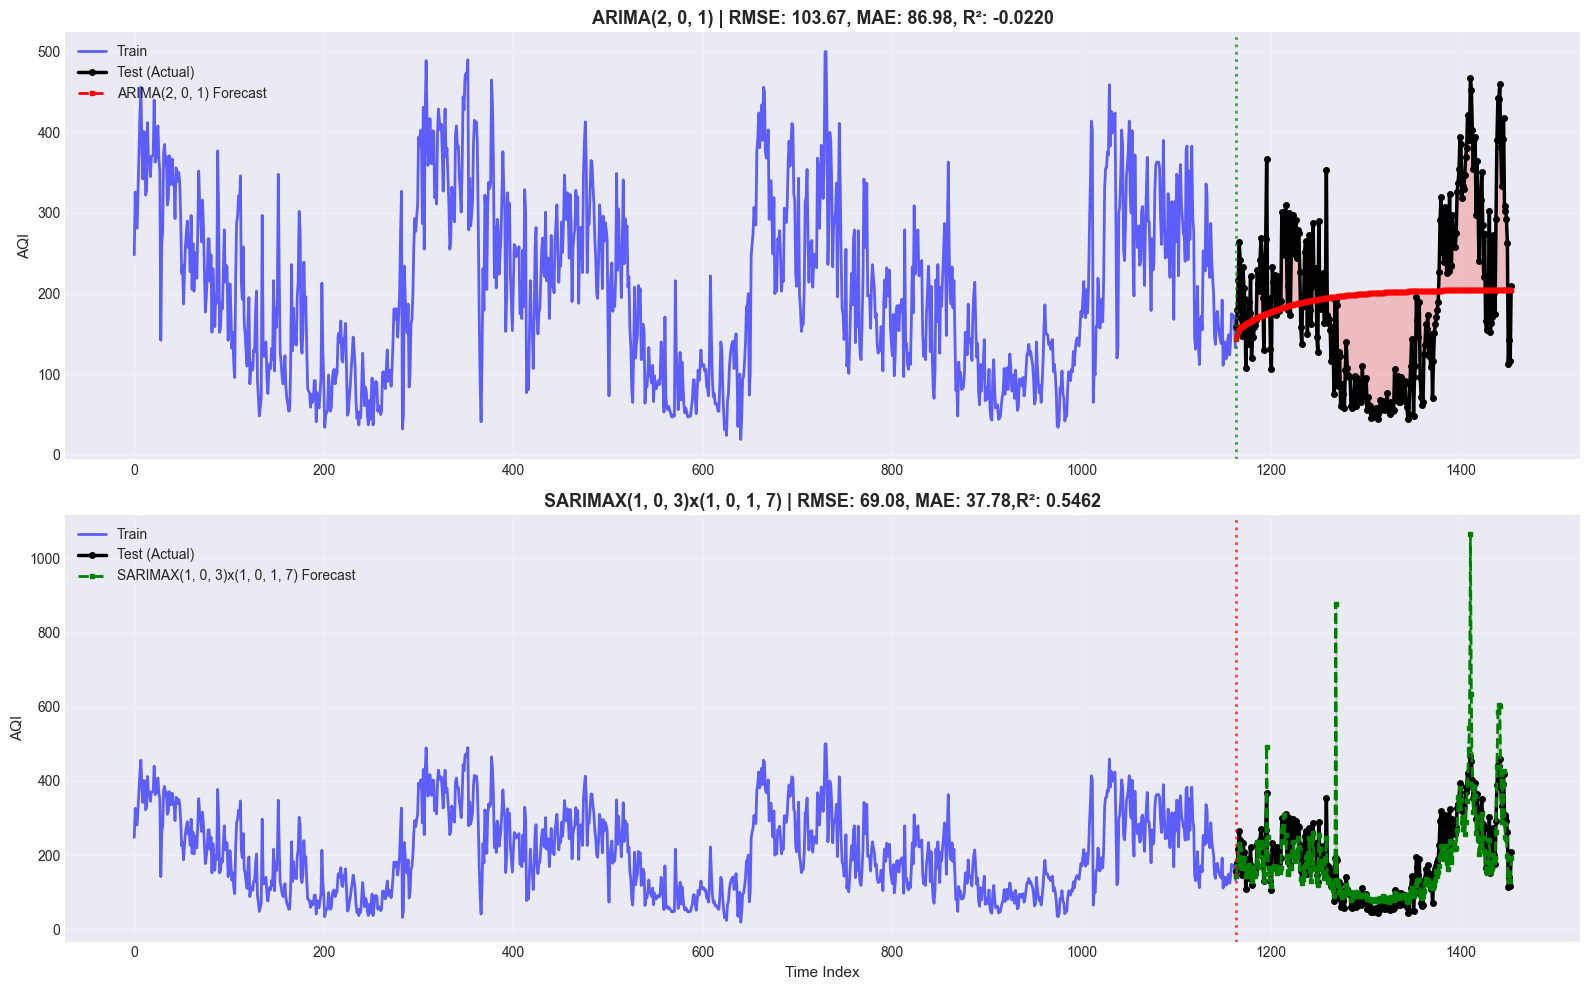

In [22]:
# ============================================
# 7. COMBINED COMPARISON VISUALIZATION
# ============================================
print("\n" + "="*70)
print("7. COMBINED FORECAST COMPARISON")
print("="*70)

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# ARIMA
axes[0].plot(range(len(train)), train, label='Train', linewidth=2, color='blue', alpha=0.6)
axes[0].plot(range(len(train), len(train) + len(test)), test, 
        label='Test (Actual)', linewidth=2.5, color='black', marker='o', markersize=4)
axes[0].plot(range(len(train), len(train) + len(test)), arima_forecast, 
        label=f'ARIMA{best_arima} Forecast', linewidth=2, linestyle='--', 
        color='red', marker='s', markersize=3)
axes[0].axvline(x=len(train), color='green', linestyle=':', linewidth=2, alpha=0.7)
axes[0].fill_between(range(len(train), len(train) + len(test)), test, arima_forecast, 
                alpha=0.2, color='red')
axes[0].set_title(f'ARIMA{best_arima} | RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}, R²: {arima_r2:.4f}', 
            fontsize=13, fontweight='bold')
axes[0].set_ylabel(target_variable, fontsize=11)
axes[0].legend(fontsize=10, loc='best')
axes[0].grid(True, alpha=0.3)

# SARIMAX
axes[1].plot(range(len(train)), train, label='Train', linewidth=2, color='blue', alpha=0.6)
axes[1].plot(range(len(train), len(train) + len(test)), test, 
        label='Test (Actual)', linewidth=2.5, color='black', marker='o', markersize=4)
axes[1].plot(range(len(train), len(train) + len(test)), sarimax_forecast, 
        label=f'SARIMAX{best_sarimax_order}x{seasonal_order} Forecast', linewidth=2, linestyle='--', 
        color='green', marker='s', markersize=3)
axes[1].axvline(x=len(train), color='red', linestyle=':', linewidth=2, alpha=0.7)
axes[1].fill_between(range(len(train), len(train) + len(test)), test, sarimax_forecast, 
                alpha=0.2, color='green')
axes[1].set_title(f'SARIMAX{best_sarimax_order}x{seasonal_order} | RMSE: {sarimax_rmse:.2f}, MAE: {sarimax_mae:.2f},R²: {sarimax_r2:.4f}', 
            fontsize=13, fontweight='bold')
axes[1].set_xlabel('Time Index', fontsize=11)
axes[1].set_ylabel(target_variable, fontsize=11)
axes[1].legend(fontsize=10, loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('all_models_forecast_comparison.png', dpi=300, bbox_inches='tight')
print("\n✅ Combined forecast comparison saved as 'all_models_forecast_comparison.png'")
plt.show()

### Combined Final Result

COMPREHENSIVE FORECASTED TREND GRAPH - ALL MODELS

🔍 Checking prediction lengths:
  Train length: 1163
  Test length (ARIMA/SARIMAX reference): 291
  XGBoost predictions: 291
  LightGBM predictions: 291
  LSTM predictions: 289
  GRU predictions: 289
  ARIMA predictions: 291
  SARIMAX predictions: 291

✅ Comprehensive forecast comparison saved as 'all_models_forecast_comparison.png'


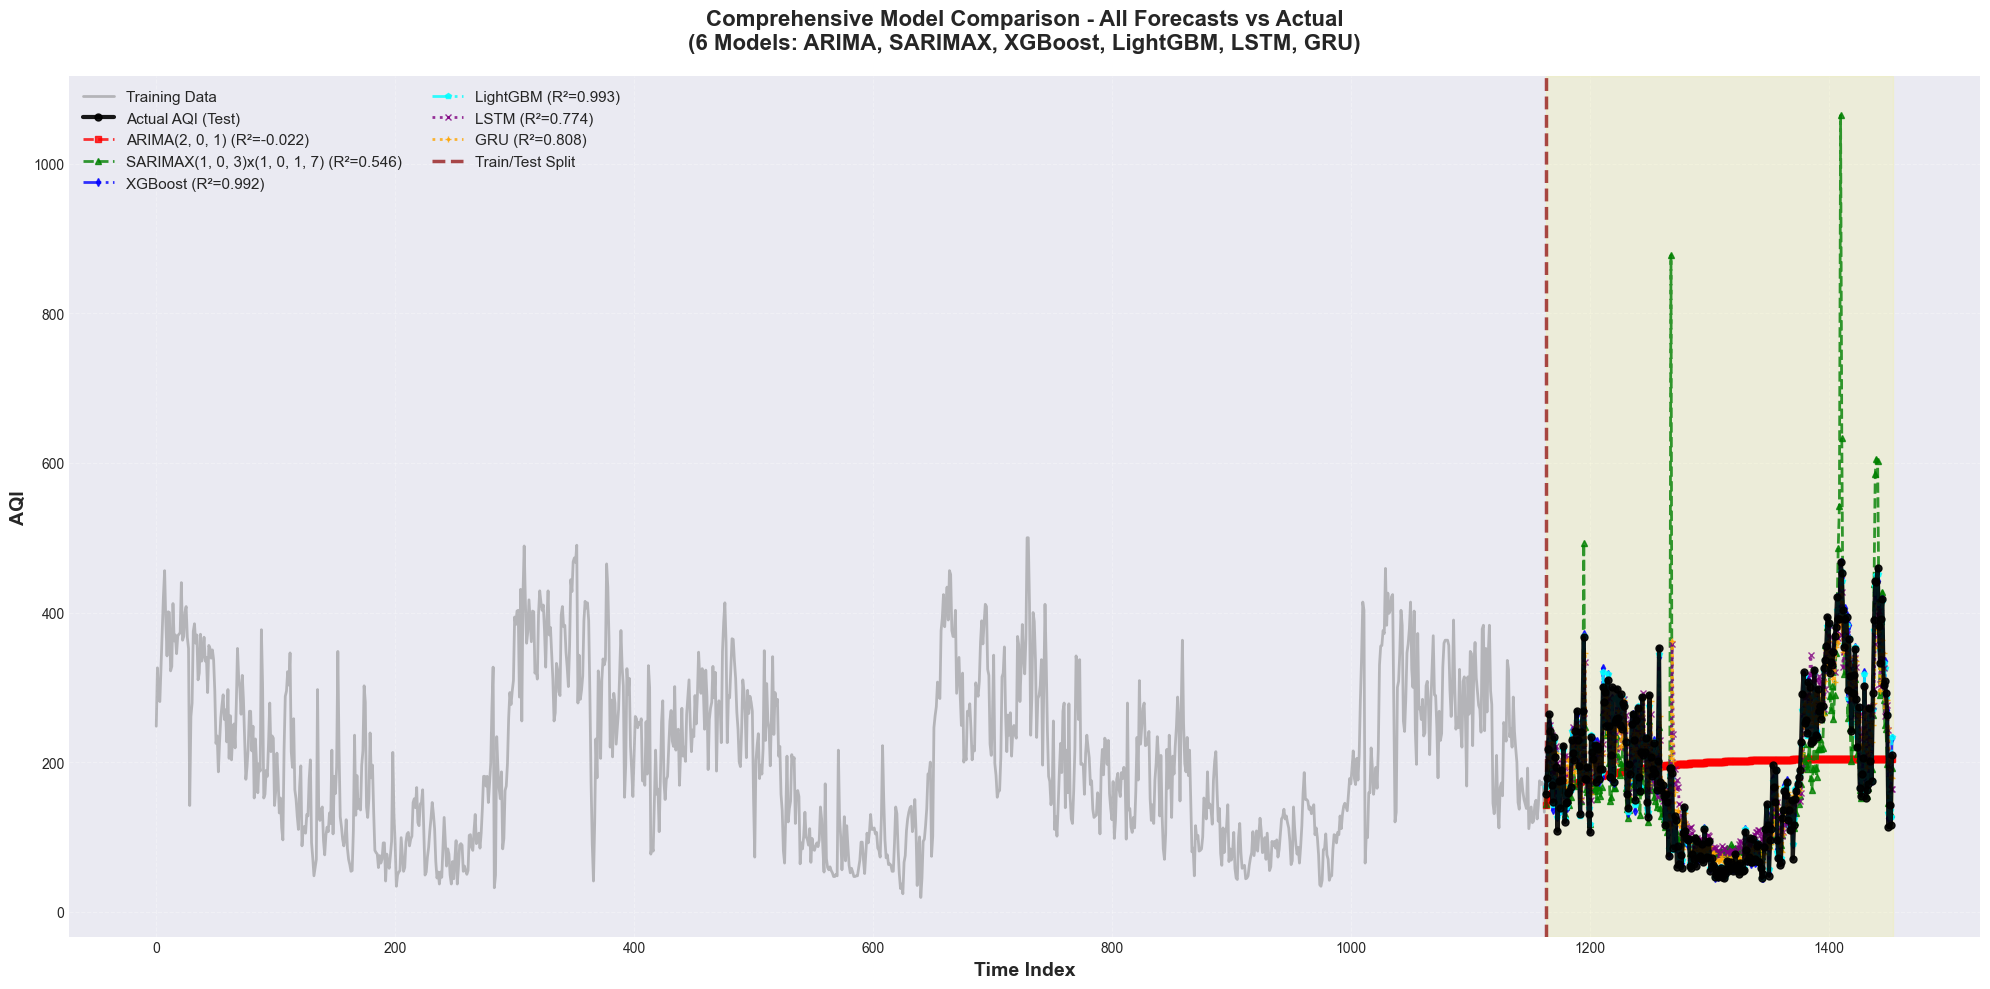


📏 Common overlap length: 289 samples
✅ Zoomed test period comparison saved as 'all_models_test_period_zoomed.png'


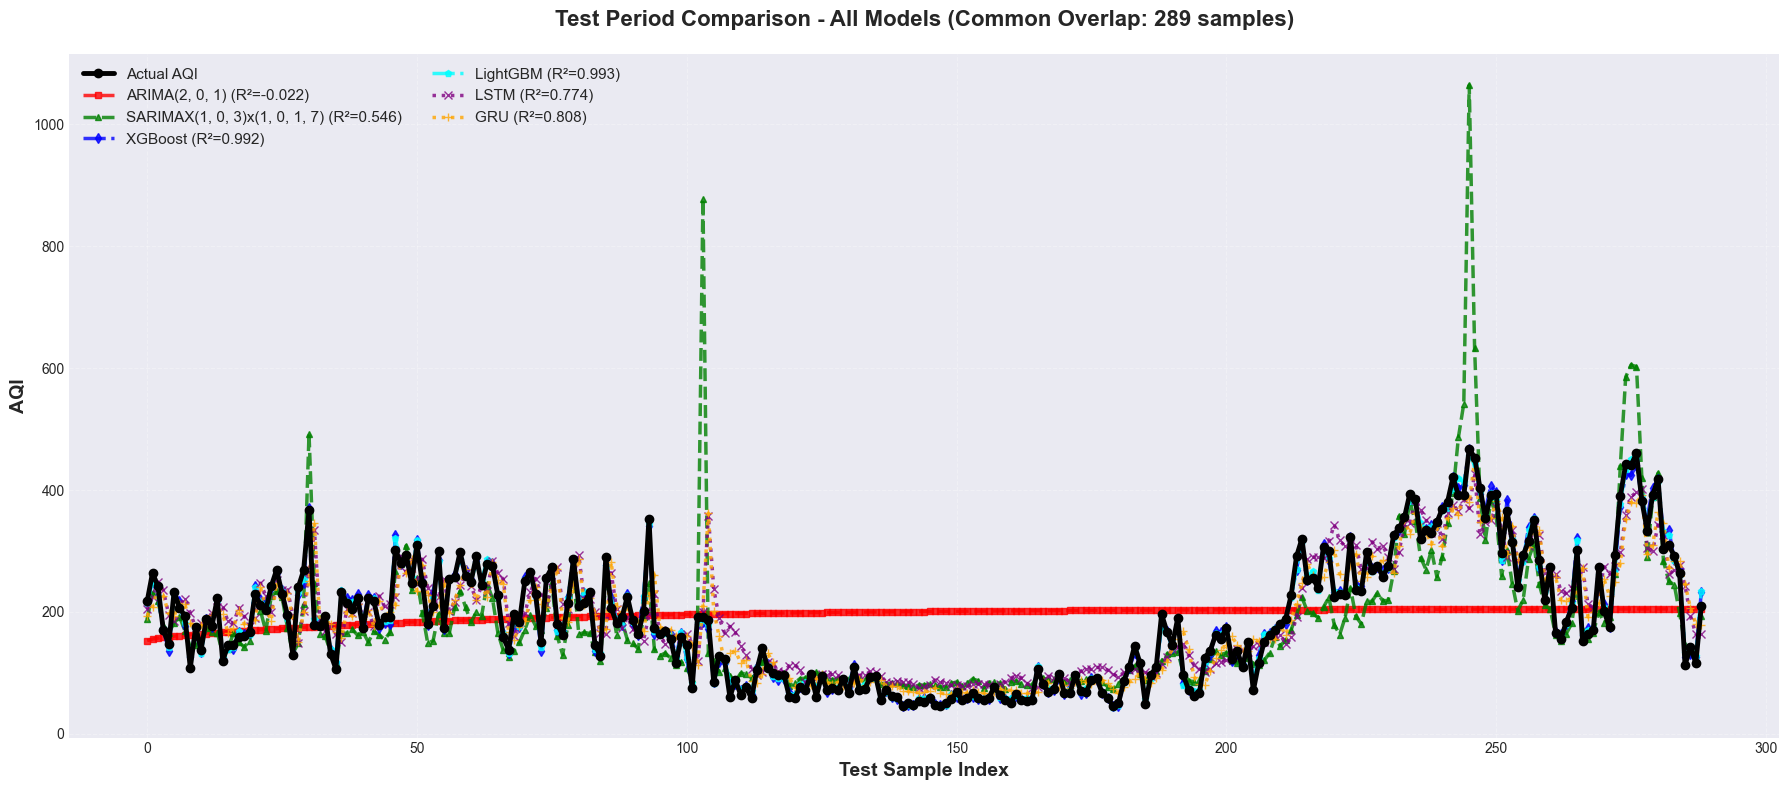

✅ Individual subplots saved as 'all_models_individual_subplots.png'


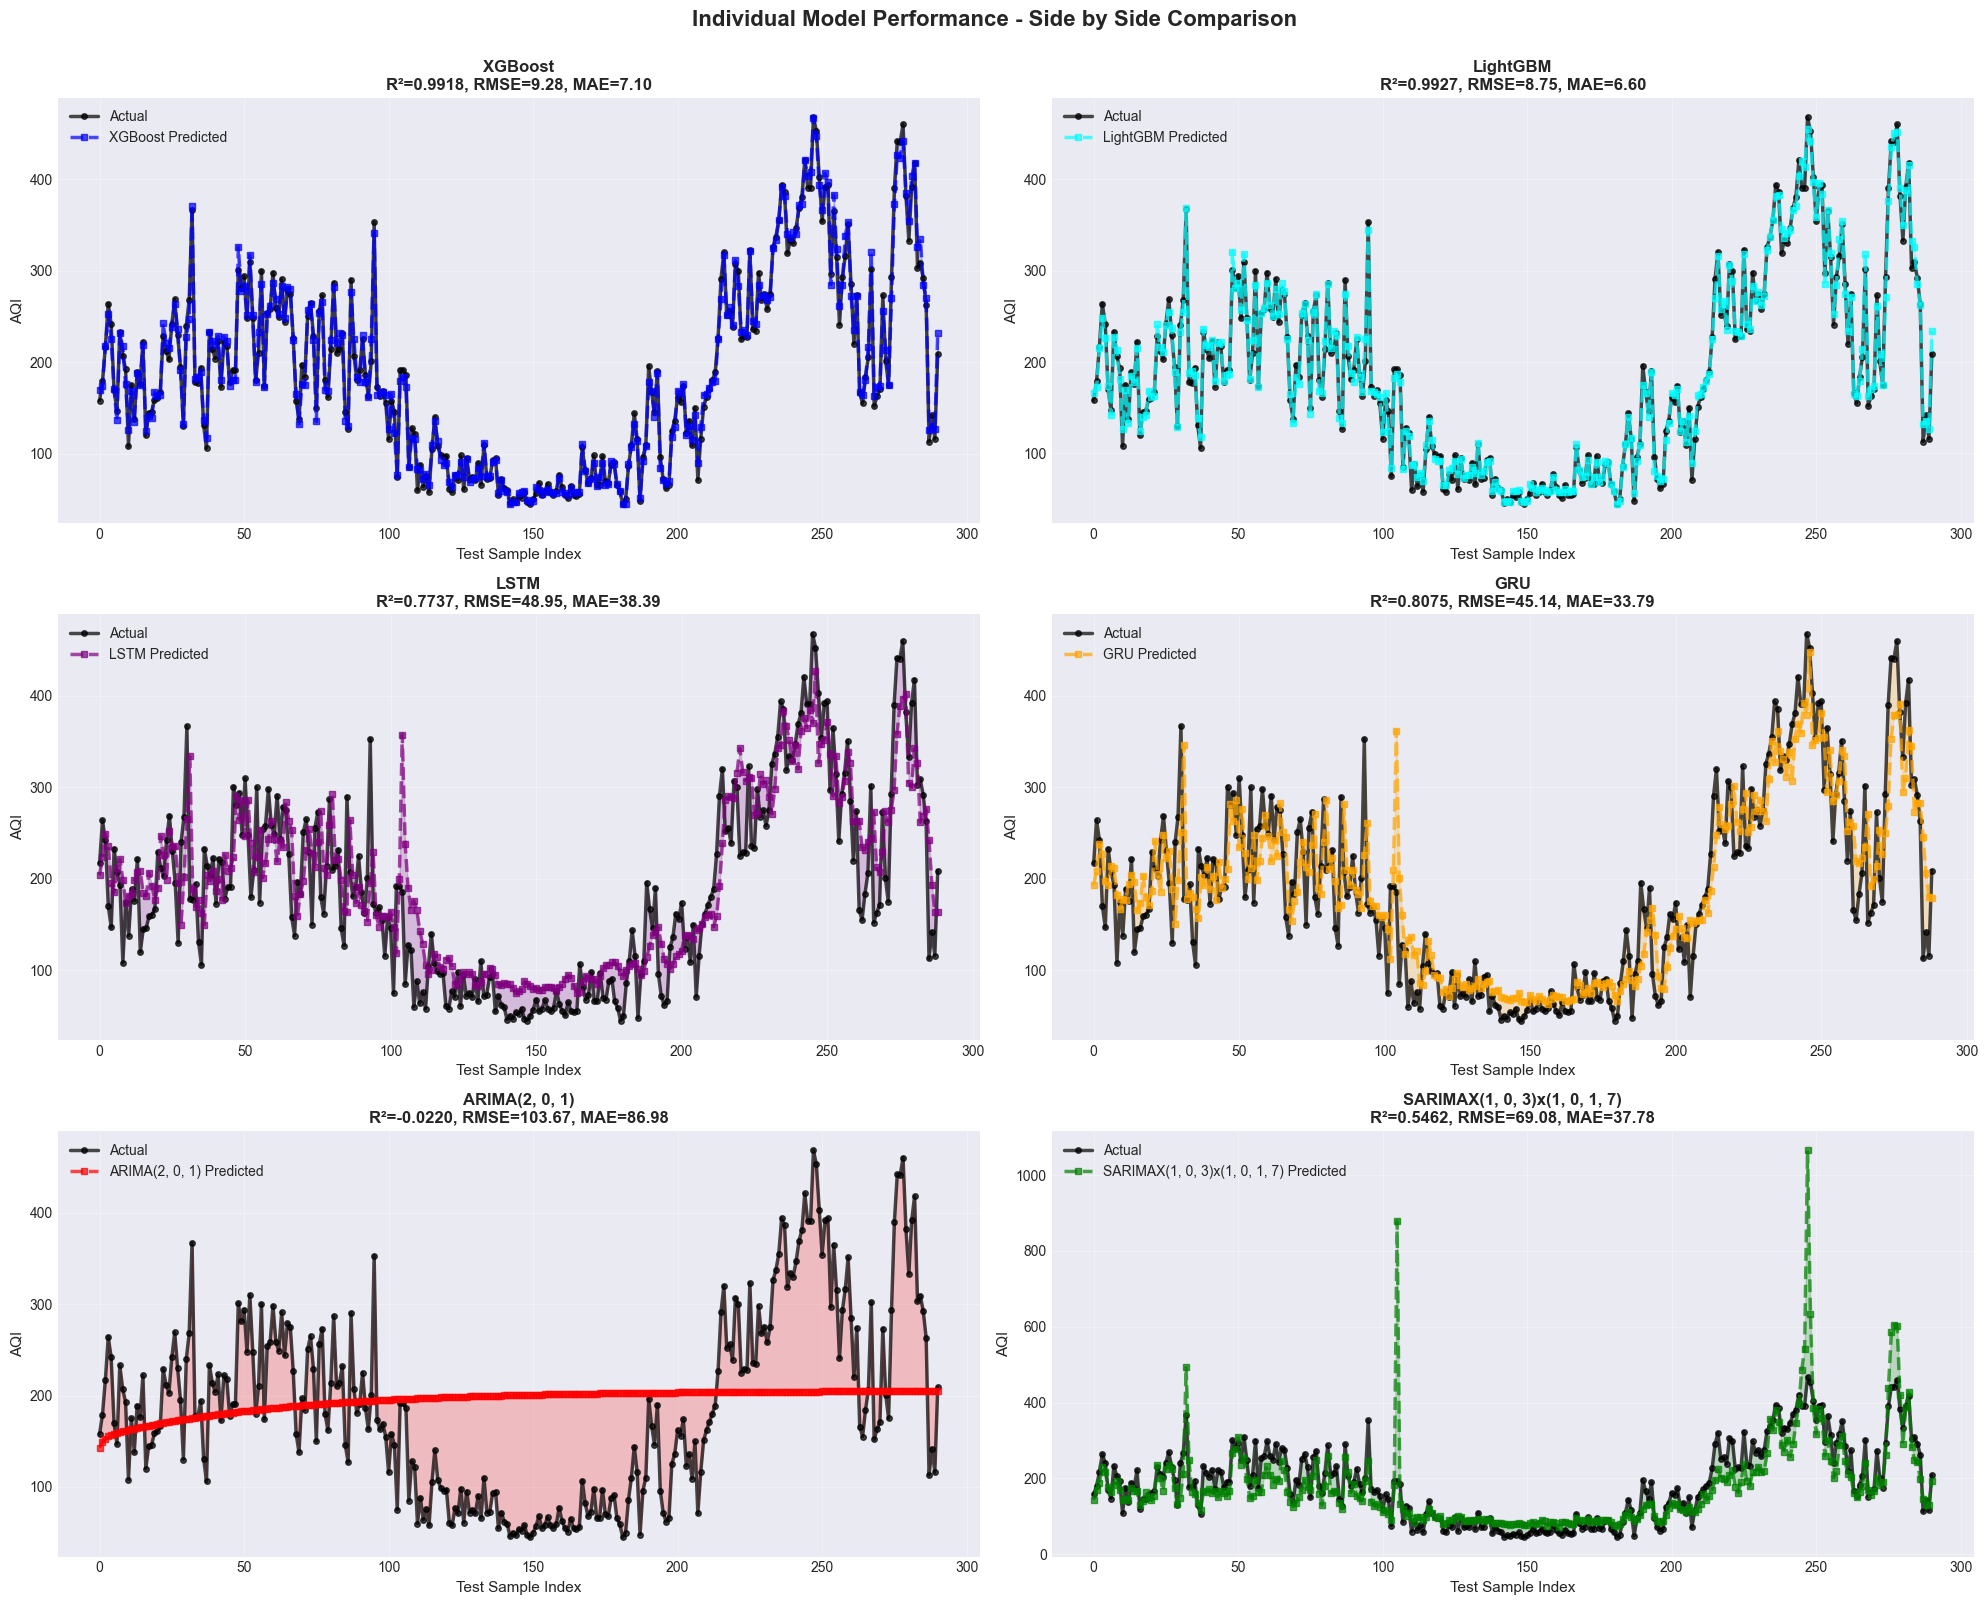

✅ Bar chart comparison saved as 'comprehensive_model_comparison_bars.png'


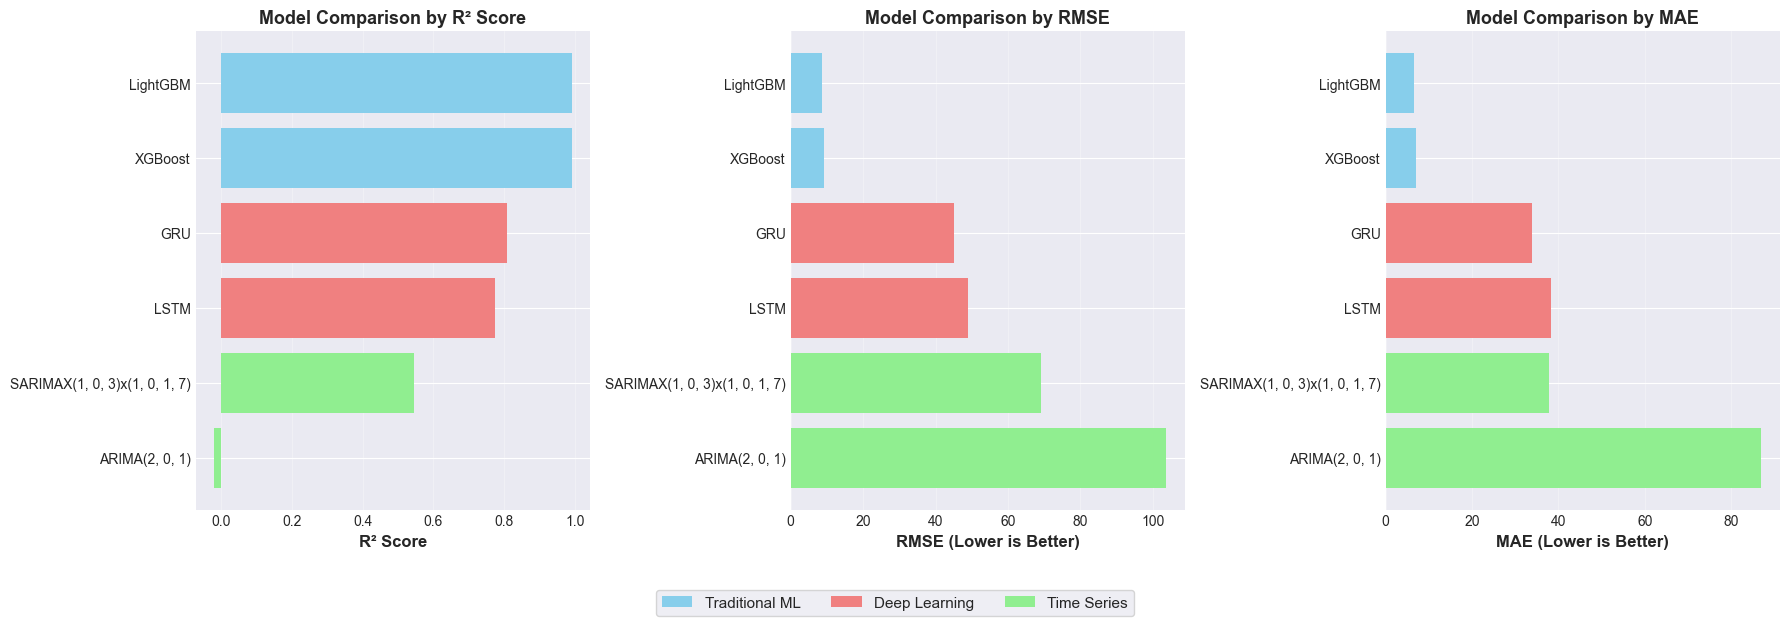


────────────────────────────────────────────────────────────────────────────────
CREATING ERROR DISTRIBUTION COMPARISON
────────────────────────────────────────────────────────────────────────────────
✅ Error distribution comparison saved as 'all_models_error_distribution.png'


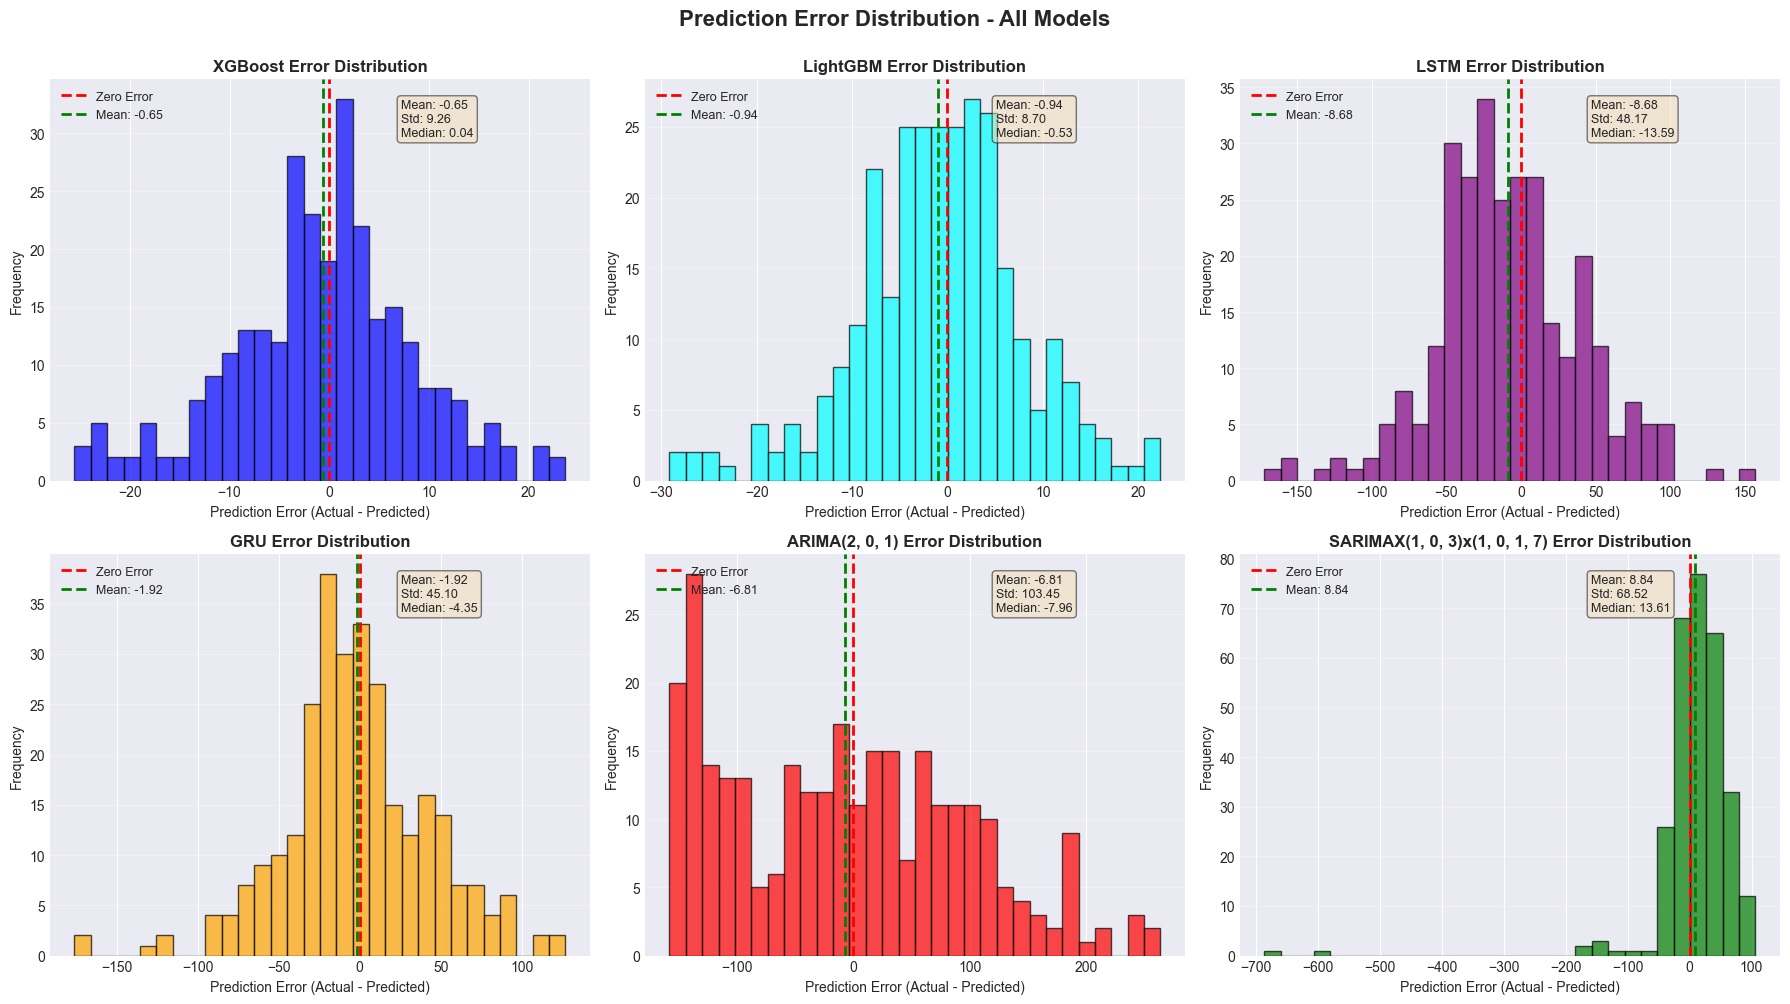

FINAL PERFORMANCE SUMMARY TABLE

      Model        R²        RMSE        MAE
1  LightGBM  0.992718    8.750988   6.597326
2   XGBoost  0.991810    9.280869   7.096926
3       GRU  0.807515   45.141214  33.792813
4      LSTM  0.773704   48.945484  38.393098
5   SARIMAX  0.546193   69.084469  37.784093
6     ARIMA -0.021987  103.673487  86.981974

🏆 BEST PERFORMING MODEL: LightGBM
   R² Score: 0.9927


In [25]:
print("COMPREHENSIVE FORECASTED TREND GRAPH - ALL MODELS")
print("="*80)
print("\n🔍 Checking prediction lengths:")
print(f"  Train length: {len(train)}")
print(f"  Test length (ARIMA/SARIMAX reference): {len(test)}")
print(f"  XGBoost predictions: {len(xgb_pred)}")
print(f"  LightGBM predictions: {len(lgb_pred)}")
print(f"  LSTM predictions: {len(lstm_pred.flatten())}")
print(f"  GRU predictions: {len(gru_pred.flatten())}")
print(f"  ARIMA predictions: {len(arima_forecast)}")
print(f"  SARIMAX predictions: {len(sarimax_forecast)}")

fig, ax = plt.subplots(figsize=(20, 10))

# Plot training data for context
ax.plot(range(len(train)), train, 
        label='Training Data', linewidth=2, color='gray', alpha=0.5)

# Plot actual test values (reference)
test_start_idx = len(train)
test_end_idx = test_start_idx + len(test)
ax.plot(range(test_start_idx, test_end_idx), test, 
        label='Actual AQI (Test)', linewidth=3, color='black', 
        marker='o', markersize=5, zorder=10, alpha=0.9)

# Plot ARIMA forecast (should match test length)
if len(arima_forecast) == len(test):
    ax.plot(range(test_start_idx, test_end_idx), arima_forecast, 
            label=f'ARIMA{best_arima} (R²={arima_r2:.3f})', 
            linewidth=2, linestyle='--', color='red', marker='s', 
            markersize=4, alpha=0.8)
else:
    print(f"⚠️  ARIMA length mismatch: expected {len(test)}, got {len(arima_forecast)}")

# Plot SARIMAX forecast
if len(sarimax_forecast) == len(test):
    ax.plot(range(test_start_idx, test_end_idx), sarimax_forecast, 
            label=f'SARIMAX{best_sarimax_order}x{seasonal_order} (R²={sarimax_r2:.3f})', 
            linewidth=2, linestyle='--', color='green', marker='^', 
            markersize=4, alpha=0.8)
else:
    print(f"⚠️  SARIMAX length mismatch: expected {len(test)}, got {len(sarimax_forecast)}")

# Plot XGBoost (align with its actual test set)
xgb_start = test_start_idx
xgb_end = xgb_start + len(xgb_pred)
ax.plot(range(xgb_start, xgb_end), xgb_pred, 
        label=f'XGBoost (R²={xgb_r2:.3f})', 
        linewidth=2, linestyle='-.', color='blue', marker='d', 
        markersize=4, alpha=0.8)

# Plot LightGBM (align with its actual test set)
lgb_start = test_start_idx
lgb_end = lgb_start + len(lgb_pred)
ax.plot(range(lgb_start, lgb_end), lgb_pred, 
        label=f'LightGBM (R²={lgb_r2:.3f})', 
        linewidth=2, linestyle='-.', color='cyan', marker='p', 
        markersize=4, alpha=0.8)

# Plot LSTM (align with its actual test set)
# LSTM/GRU typically have fewer samples due to sequence requirements
lstm_start = test_end_idx - len(lstm_pred.flatten())
lstm_end = test_end_idx
ax.plot(range(lstm_start, lstm_end), lstm_pred.flatten(), 
        label=f'LSTM (R²={lstm_r2:.3f})', 
        linewidth=2, linestyle=':', color='purple', marker='x', 
        markersize=4, alpha=0.8)

# Plot GRU (align with its actual test set)
gru_start = test_end_idx - len(gru_pred.flatten())
gru_end = test_end_idx
ax.plot(range(gru_start, gru_end), gru_pred.flatten(), 
        label=f'GRU (R²={gru_r2:.3f})', 
        linewidth=2, linestyle=':', color='orange', marker='+', 
        markersize=4, alpha=0.8)

# Add vertical line to separate train/test
ax.axvline(x=len(train), color='darkred', linestyle='--', 
          linewidth=2.5, alpha=0.7, label='Train/Test Split')

# Add shaded region for test period
ax.axvspan(test_start_idx, test_end_idx, alpha=0.1, color='yellow')

# Styling
ax.set_xlabel('Time Index', fontsize=14, fontweight='bold')
ax.set_ylabel('AQI', fontsize=14, fontweight='bold')
ax.set_title('Comprehensive Model Comparison - All Forecasts vs Actual\n(6 Models: ARIMA, SARIMAX, XGBoost, LightGBM, LSTM, GRU)', 
            fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=11, framealpha=0.9, ncol=2)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('all_models_forecast_comparison.png', dpi=300, bbox_inches='tight')
print("\n✅ Comprehensive forecast comparison saved as 'all_models_forecast_comparison.png'")
plt.show()

# Find the common overlap period for all models
min_pred_length = min(len(test), len(xgb_pred), len(lgb_pred), 
                      len(lstm_pred.flatten()), len(gru_pred.flatten()),
                      len(arima_forecast), len(sarimax_forecast))

print(f"\n📏 Common overlap length: {min_pred_length} samples")

fig, ax = plt.subplots(figsize=(18, 8))

# Use only the common overlap period
test_indices = range(min_pred_length)

# Plot all models on the same scale
ax.plot(test_indices, test[-min_pred_length:], 
        label='Actual AQI', linewidth=3.5, color='black', 
        marker='o', markersize=6, zorder=10)

ax.plot(test_indices, arima_forecast[-min_pred_length:], 
        label=f'ARIMA{best_arima} (R²={arima_r2:.3f})', 
        linewidth=2.5, linestyle='--', color='red', 
        marker='s', markersize=5, alpha=0.8)

ax.plot(test_indices, sarimax_forecast[-min_pred_length:], 
        label=f'SARIMAX{best_sarimax_order}x{seasonal_order} (R²={sarimax_r2:.3f})', 
        linewidth=2.5, linestyle='--', color='green', 
        marker='^', markersize=5, alpha=0.8)

ax.plot(test_indices, xgb_pred[-min_pred_length:], 
        label=f'XGBoost (R²={xgb_r2:.3f})', 
        linewidth=2.5, linestyle='-.', color='blue', 
        marker='d', markersize=5, alpha=0.8)

ax.plot(test_indices, lgb_pred[-min_pred_length:], 
        label=f'LightGBM (R²={lgb_r2:.3f})', 
        linewidth=2.5, linestyle='-.', color='cyan', 
        marker='p', markersize=5, alpha=0.8)

ax.plot(test_indices, lstm_pred.flatten()[-min_pred_length:], 
        label=f'LSTM (R²={lstm_r2:.3f})', 
        linewidth=2.5, linestyle=':', color='purple', 
        marker='x', markersize=6, alpha=0.8)

ax.plot(test_indices, gru_pred.flatten()[-min_pred_length:], 
        label=f'GRU (R²={gru_r2:.3f})', 
        linewidth=2.5, linestyle=':', color='orange', 
        marker='+', markersize=6, alpha=0.8)

# Styling
ax.set_xlabel('Test Sample Index', fontsize=14, fontweight='bold')
ax.set_ylabel('AQI', fontsize=14, fontweight='bold')
ax.set_title(f'Test Period Comparison - All Models (Common Overlap: {min_pred_length} samples)', 
            fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=11, framealpha=0.9, ncol=2)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('all_models_test_period_zoomed.png', dpi=300, bbox_inches='tight')
print("✅ Zoomed test period comparison saved as 'all_models_test_period_zoomed.png'")
plt.show()

fig, axes = plt.subplots(3, 2, figsize=(20, 16))
axes = axes.flatten()

# Prepare data - use actual test data aligned with each model's predictions
models_data = [
    ('XGBoost', xgb_pred, xgb_r2, xgb_rmse, 'blue', 
     test[-len(xgb_pred):] if len(xgb_pred) <= len(test) else test),
    
    ('LightGBM', lgb_pred, lgb_r2, lgb_rmse, 'cyan', 
     test[-len(lgb_pred):] if len(lgb_pred) <= len(test) else test),
    
    ('LSTM', lstm_pred.flatten(), lstm_r2, lstm_rmse, 'purple', 
     test[-len(lstm_pred.flatten()):]),
    
    ('GRU', gru_pred.flatten(), gru_r2, gru_rmse, 'orange', 
     test[-len(gru_pred.flatten()):]),
    
    (f'ARIMA{best_arima}', arima_forecast, arima_r2, arima_rmse, 'red', 
     test[:len(arima_forecast)]),
    
    (f'SARIMAX{best_sarimax_order}x{seasonal_order}', sarimax_forecast, 
     sarimax_r2, sarimax_rmse, 'green', test[:len(sarimax_forecast)])
]

for idx, (model_name, predictions, r2, rmse, color, actual) in enumerate(models_data):
    ax = axes[idx]
    
    # Ensure same length
    min_len = min(len(actual), len(predictions))
    actual_plot = actual[:min_len]
    pred_plot = predictions[:min_len]
    
    # Plot actual and predicted
    ax.plot(actual_plot, label='Actual', linewidth=2.5, color='black', 
           marker='o', markersize=4, alpha=0.7)
    ax.plot(pred_plot, label=f'{model_name} Predicted', linewidth=2.5, 
           color=color, marker='s', markersize=4, alpha=0.7, linestyle='--')
    
    # Fill between for error visualization
    ax.fill_between(range(min_len), actual_plot, pred_plot, 
                    alpha=0.2, color=color)
    
    # Calculate and display additional metrics
    mae = mean_absolute_error(actual_plot, pred_plot)
    
    # Styling
    ax.set_title(f'{model_name}\nR²={r2:.4f}, RMSE={rmse:.2f}, MAE={mae:.2f}', 
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Test Sample Index', fontsize=11)
    ax.set_ylabel('AQI', fontsize=11)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.suptitle('Individual Model Performance - Side by Side Comparison', 
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('all_models_individual_subplots.png', dpi=300, bbox_inches='tight')
print("✅ Individual subplots saved as 'all_models_individual_subplots.png'")
plt.show()

# 1. Bar Chart Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

models = comprehensive_df_sorted['Model'].values
categories = comprehensive_df_sorted['Category'].values
colors = {'Traditional ML': 'skyblue', 'Deep Learning': 'lightcoral', 'Time Series': 'lightgreen'}
bar_colors = [colors[cat] for cat in categories]

# R² Score
axes[0].barh(models, comprehensive_df_sorted['R² Score'], color=bar_colors)
axes[0].set_xlabel('R² Score', fontsize=12, fontweight='bold')
axes[0].set_title('Model Comparison by R² Score', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# RMSE
axes[1].barh(models, comprehensive_df_sorted['RMSE'], color=bar_colors)
axes[1].set_xlabel('RMSE (Lower is Better)', fontsize=12, fontweight='bold')
axes[1].set_title('Model Comparison by RMSE', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

# MAE
axes[2].barh(models, comprehensive_df_sorted['MAE'], color=bar_colors)
axes[2].set_xlabel('MAE (Lower is Better)', fontsize=12, fontweight='bold')
axes[2].set_title('Model Comparison by MAE', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='x')
axes[2].invert_yaxis()

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[cat], label=cat) for cat in colors.keys()]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), 
          ncol=3, fontsize=11, frameon=True)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('comprehensive_model_comparison_bars.png', dpi=300, bbox_inches='tight')
print("✅ Bar chart comparison saved as 'comprehensive_model_comparison_bars.png'")
plt.show()

# ============================================
# PLOT 4: ERROR DISTRIBUTION COMPARISON
# ============================================
print("\n" + "─"*80)
print("CREATING ERROR DISTRIBUTION COMPARISON")
print("─"*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (model_name, predictions, r2, rmse, color, actual) in enumerate(models_data):
    ax = axes[idx]
    
    # Ensure same length for error calculation
    min_len = min(len(actual), len(predictions))
    actual_err = actual[:min_len]
    pred_err = predictions[:min_len]
    
    # Calculate errors
    errors = actual_err - pred_err
    
    # Plot histogram
    n, bins, patches = ax.hist(errors, bins=30, color=color, alpha=0.7, edgecolor='black')
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    ax.axvline(x=np.mean(errors), color='green', linestyle='--', linewidth=2, 
              label=f'Mean: {np.mean(errors):.2f}')
    
    # Add statistics text box
    textstr = f'Mean: {np.mean(errors):.2f}\nStd: {np.std(errors):.2f}\nMedian: {np.median(errors):.2f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.65, 0.95, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=props)
    
    # Styling
    ax.set_title(f'{model_name} Error Distribution', 
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Prediction Error (Actual - Predicted)', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.legend(fontsize=9, loc='upper left')
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Prediction Error Distribution - All Models', 
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('all_models_error_distribution.png', dpi=300, bbox_inches='tight')
print("✅ Error distribution comparison saved as 'all_models_error_distribution.png'")
plt.show()

print("FINAL PERFORMANCE SUMMARY TABLE")
print("="*80)
model_names = ['XGBoost', 'LightGBM', 'LSTM', 'GRU', 'ARIMA', 'SARIMAX']
r2_scores = [xgb_r2, lgb_r2, lstm_r2, gru_r2, arima_r2, sarimax_r2]
rmse_scores = [xgb_rmse, lgb_rmse, lstm_rmse, gru_rmse, arima_rmse, sarimax_rmse]
mae_scores = [xgb_mae, lgb_mae, lstm_mae, gru_mae, arima_mae, sarimax_mae]

summary_df = pd.DataFrame({
    'Model': model_names,
    'R²': r2_scores,
    'RMSE': rmse_scores,
    'MAE': mae_scores
})

# Sort by R² (descending)
summary_df = summary_df.sort_values('R²', ascending=False).reset_index(drop=True)
summary_df.index = summary_df.index + 1  # Start from 1

print("\n" + summary_df.to_string())

# Identify best model
best_model = summary_df.iloc[0]['Model']
best_r2 = summary_df.iloc[0]['R²']

print("\n" + "="*80)
print(f"🏆 BEST PERFORMING MODEL: {best_model}")
print(f"   R² Score: {best_r2:.4f}")
print("="*80)